In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
from datetime import timezone
from dateutil.tz import *
import matplotlib.dates as mdates
from datetime import timedelta
import os
from model_utils import *
import matplotlib.dates as dates

#from iri2016 import timeprofile, timeprofile2

In [2]:
'''
;  PURPOSE:
;    The VDRIFT_MODEL procedure is the main routine for obtaining vertical drifts. The vertical drifts
;    dependences of the local time and longitudinal (See details in Scherlies and Fejer, 1999). 
;  INPUTS:
;    DOY = A scalar of integer type giving the Day of year. (e.g. doy = 347)
;    HOUR = Set this keyword to an integer  from 00 to 23 to define the hour (00... 24hrs). By default 
;      hour =12.
;    F107CM = A scalar giving the solar flux F10.7cm. By default it will take 150.
;    LONGITUDE = Geographic Longitude.    
;  OUTPUTS:
;    vdrift= vertical drifts
'''

def drift_model2(year, doy,longitude):
    if doy == 0:
        doy = 161
    if longitude ==0:
        longitude = 270.0
    #constant = longitude
    start = 7.0
    finish = 19.0
    nsteps = 72
    step = int(finish-start)/nsteps
    ###############################################################
    #st = 0.0
    end = finish
    #nsteps = step
    a = np.linspace(start,end,nsteps, endpoint=False)
    minutos = []
    horas = []
    for t in a:
        hour, minute = divmod(t, 1)
        minute *= 60
        result = '{}:{}'.format(int(hour), int(minute))
        #print(result)
        horas.append(int(hour))
        minutos.append(int(minute))
    ###################
    #year = 2020
    d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
    ###################
    m = np.zeros(nsteps)
    steps = np.zeros(nsteps)
    #FOR i=start,(finish*(1+(profil EQ 0))) DO steps[i]=i*step
    j=0
    f107_list = []#getIndexF107(year, doy, hour)
    datetime_list = []
    for i in np.linspace(start,finish,nsteps,endpoint=False):
        steps[j]=i*step
        temp = i#start + i*step
        steps[j] = temp
        str_time = '%d-%02d-%02d %02d:%02d:%02d' % (year, d.month, d.day,horas[j], minutos[j],0)
        dt = datetime.datetime.strptime(str_time, '%Y-%m-%d %H:%M:%S')
        datetime_list.append(dt)
        #print('i:', int(i))
        f107_list.append(getIndexF107(year, doy, int(i)))
        j = j + 1
    time = steps
    yv = []
    #Calling VDrifts to compute vertical drifts.
    for ii in range(0,(nsteps-1) + 1):
        xt=time[ii]
        xl=longitude
        y=vdrift(xt,xl,doy,f107_list[ii])
        yv.append(y)
    return np.array(yv),np.array(datetime_list)

In [3]:
def GetMatrix_old(directory, filename, PlotFlag, plot_format):
    ##########################################################
    ## 2020-06-16: Se verificó que la función trabaja
    ## correctamente. Se creara una nueva para hacer pruebas 
    ## con las dimensiones
    ##########################################################
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    #with h5py.File(file_hf5, 'r') as f:
    #    g = f.visit(print)
    days = np.array(hf['Data/Table Layout/']['day'],dtype=int)
    year = np.array(hf['Data/Table Layout/']['year'],dtype=int)
    month = np.array(hf['Data/Table Layout/']['month'],dtype=int)
    hour = np.array(hf['Data/Table Layout/']['hour'],dtype=int)
    minutes = np.array( hf['Data/Table Layout/']['min'],dtype=int)
    seconds = np.array(hf['Data/Table Layout/']['sec'],dtype=int)
    rango = hf['Data/Table Layout/']['gdalt']
    #rango2D = hf['Data/Array Layout/']['range']
    #Data/Array Layout/timestamps
    timestamps = hf['Data/Array Layout/']['timestamps']
    snl =  hf['Data/Table Layout/']['snl']
    snl2 = np.array(hf['Data/Array Layout/2D Parameters/snl']).T
      
    vipe1 = np.array(hf['Data/Array Layout/2D Parameters/vipe']).T
    vipn1 = np.array(hf['Data/Array Layout/2D Parameters/vipn']).T
    v_zonal = vipe1
    v_vertical = vipn1
    #snl2 = np.array(snl2)
    time_vector = []
    date_list = [] # list for datetime objects
    datetimeFormat = '%Y-%m-%d %H:%M:%S'
    for y, m, d,h, mmins, sec in zip(year,month,days,hour,minutes,seconds):
        date_string = '%d-%02d-%02d %02d:%02d:%02d' % (y,m,d,h,mmins,sec)
        date = datetime.datetime(y,m,d,h,mmins, sec)#, datetimeFormat)
        time_vector.append(date_string)
        date_list.append(date)
    #####################################################################
    index = pd.DatetimeIndex(date_list) - timedelta(hours=5)
    date_list = [] # list for datetime objects
    datetimeFormat = '%Y-%m-%d %H:%M:%S'
    prev_stamps = []
    datetime_objects = []
    for ts in timestamps:
        if ts in prev_stamps:
            print('Same timestap')
        else:
            date_time_obj = datetime.datetime.fromtimestamp(ts)
            datetime_objects.append(date_time_obj)
    index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
    datetime_objects = np.array(datetime_objects)#,dtype='datetime64[s]')
     ##########################################################
    # Aquí viene la conversión a listas 
    #converted_value = getattr(value, "tolist", lambda: value)()
    days = getattr(days, "tolist", lambda: days)()
    year = getattr(year, "tolist", lambda: year)()
    month = getattr(month, "tolist", lambda: month)()
    hour = getattr(hour, "tolist", lambda: hour)()
    minutes = getattr(minutes, "tolist", lambda: minutes)()
    seconds = getattr(seconds, "tolist", lambda: seconds)()
    rango = getattr(rango, "tolist", lambda: rango)()
    ###########################################################
    ran_max = max(rango)
    ran_min = min(rango)
    #rang_list = list(rango)
    max_index = rango.index(ran_max)
    min_index = rango.index(ran_min)
    range_diff = np.diff(rango)
    delta_range = range_diff[0] #valor constante para todo el arreglo
    MinRange, MaxRange = np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    DataMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    RowInMatrix = np.array((rango-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #DataMatrix_v_zonal = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #DataMatrix_v_vertical = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    
    string_date = index[0].strftime('%B %d, %Y, %r')
    #line.split()[0]
    #mes = string_date.split()[0]
    month_prime = index[0].month
    #if mes == 'June':
    #    mes ='Junio'
    #if mes == 'July':
    #    mes = 'Julio'
    #if mes == 'August':
    #    mes ='Agosto'
    mes = GetMonth(month_prime)
    dia = index[0].day
    anio = index[0].year
    
    dir_plots = 'Plots-150km-%s-%d' % (mes, anio)
    dir_plots_EEJ = 'Plots-150km-%s-%d/EEJ' % (mes, anio)
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    #print("range(rango.size) ",range(rango.size))
    for k in range(len(rango)):
        row = RowInMatrix[k] 
    # Putting snr in corresponding matrix element
        DataMatrix[row,col] = snl[k]
        if row<PastRow:
            col += 1
        PastRow = row
    data = DataMatrix#[::-1]
    ######################################################################
    v_vertical_avg = np.nanmean(v_vertical,axis=1)
    v_vertical_std = np.nanstd(v_vertical,axis=1)
    #.groupby(lambda x: (x.year, x.month, x.hour, x.minute)).vals.mean()
    #line.split()[0]
    #mes = #string_date.split()[0]
    mes = datetime_objects[0].month
    month_str = GetMonth(mes)
    day = datetime_objects[0].day
    year = datetime_objects[0].year
    
    #dir_plots = 'Plots-%s-%d' % (month_str, anio)
    #print(dir_plots)
    df_vertical = pd.DataFrame({'vz':v_vertical_avg,'std_vz':v_vertical_std})
    df_vertical.set_index(index,inplace=True)
    #df_zonal_final = df_zonal.resample('30Min').mean()#.interpolate()#["vz"].plot()#interpolate()
    str_vertical_csv = 'derivas-verticales-%02d-%02d-%02d.csv' % (year, mes,day)
    df_vertical.to_csv(str_vertical_csv)
    #######################################################################################################
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        
        #plt.style.use('dark_background')
        x_min = mdates.date2num(np.min(index))
        x_max = mdates.date2num(np.max(index))
        extent=[x_min, x_max,ran_min,ran_max]
        im2 = plt.imshow(data, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb2 = fig.colorbar(im2)
        cb2.set_label(r'$log_{10}SNR$', fontsize=17)
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')

        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)
    #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.rcParams['xtick.labelsize']=15
        #plt.style.use('dark_background')
        #plt.style.use('dark_background')
        im3 = plt.imshow(v_vertical.T, cmap='RdBu_r',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        #im3 = plt.imshow(v_vertical.T, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)

        linePos1 = datetime.datetime(datetime_objects[0].year,datetime_objects[0].month,datetime_objects[0].day,7,30,0)
        linePos2 = datetime.datetime(datetime_objects[0].year,datetime_objects[0].month,datetime_objects[0].day,10,30,0)        
        #plt.axvline(x=mdates.date2num(linePos1),color='black')
        #plt.axvline(x=mdates.date2num(linePos2),color='black')        
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H')
        dt0 = datetime.datetime(datetime_objects[0].year,datetime_objects[0].month,datetime_objects[0].day,7,0,0)
        dt1 = datetime.datetime(datetime_objects[0].year,datetime_objects[0].month,datetime_objects[0].day,7,45,0)
        dt2 = datetime.datetime(datetime_objects[0].year,datetime_objects[0].month,datetime_objects[0].day,9,45,0)
        dt3 = datetime.datetime(datetime_objects[0].year,datetime_objects[0].month,datetime_objects[0].day,17,0,0)
        ax.set_xlim(dt0,dt3)
        ax.axvline(dt1,linestyle='--')
        ax.axvline(dt2,linestyle='--')
        
        ax.xaxis.set_major_formatter(date_format)
        #ax.set_xlabel("Hora Local (h)", fontsize=15)
        ax.set_xlabel("UTC (h)", fontsize=15)
        ax.set_ylabel("Rango (km)", fontsize=15)
        #x_label_list = ['12', '13', '14', '15','16','17','18','19','20']
        #ax.set_xticks([20,40,60,80])
        #ax.set_xticklabels(x_label_list)
        fig_title = r'Derivas Verticales - Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=17)
        ax.set_ylim(130,170)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb3 = fig.colorbar(im3)
        plot_format = 'png'
        cb3.set_label(r'Velocidad vertical (m/s)', fontsize=15)
        cb3.mappable.set_clim(-30,40)
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-v-vertical.%s' % (dir_plots,anio, month_prime, dia, plot_format),bbox_inches="tight")
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)   
        plt.style.use('default')

    #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.style.use('dark_background')
        #plt.rcParams['xtick.labelsize']=14
        im4 = plt.imshow(v_zonal.T, cmap='RdBu',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb4 = fig.colorbar(im4)
        cb4.set_label(r'Velocidad zonal (m/s)', fontsize=15)
        cb4.mappable.set_clim(-20,20)

        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-v-zonal.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)   
        ############################################################3
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        #plt.style.use('dark_background')
        im3 = plt.imshow(data, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)

        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        #ax.set_xlim(90,130)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb3 = fig.colorbar(im3)
        cb3.set_label(r'EEJ', fontsize=15)
        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/eej-ecos-150km-%d-%02d-%02d-v-vertical.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)   
    
    return  data ,snl, index, range_array, rango, dir_plots, time_vector, v_zonal, v_vertical, timestamps, snl2

In [4]:
def AddNaN(a,b):
    result = np.add(a,b)

    a_is_nan = np.isnan(a)
    b_is_nan = np.isnan(b)

    result_is_nan = np.isnan(result)

    mask_a = np.logical_and(result_is_nan, np.logical_not(a_is_nan))
    result[mask_a] = a[mask_a]

    mask_b = np.logical_and(result_is_nan, np.logical_not(b_is_nan))
    result[mask_b] = b[mask_b]

    return result


In [5]:
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))
    

In [6]:
def GetBinaryMatrix(d_prima):
    d_prima = d_prom.copy()
#d_prima[d_prima==np.nan]=0
#d_prima[d_prima!=np.nan]=1
    fils, cols = d_prima.shape
    matCount = np.zeros(d_prima.shape)
    for i in range(fils):
        for j in range(cols):
            if np.isnan(d_prima[i,j]):
                d_prima[i,j]=0
            #matCount[i,j]+=1
            else:
                d_prima[i,j]=1
                matCount[i,j]+=1
    return d_prima, matCount

In [7]:
def GetTimeRangeArrays(year, month, day, hour_i, hour_f, h_min, h_max, delta_ran, intFactor):
    range_fixed = np.arange(h_min,h_max,delta_ran)
    string_t0 = '%d-%02d-%02d %02d:00:00' % (year, month, day, hour_i)
    string_tf = '%d-%02d-%02d %02d:00:00' % (year, month, day, hour_f)
    dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
    dtf = datetime.datetime.strptime(string_tf, '%Y-%m-%d %H:%M:%S')# + timedelta(days=1)
#ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
    time_range = np.arange(dt0,dtf,timedelta(seconds=intFactor*60)).astype(datetime.datetime)
    print(time_range[1]-time_range[0])
    print("time_range.shape: ", time_range.shape)
    #print("Type: ", type(time_range[0]))
    #time_range = np.array(time_range).astype(datetime.datetime)#,dtype='datetime64[s]')
    return time_range, range_fixed

In [32]:
year = 2012
month = 4
intFactor = 1#10
str_month = GetMonth(month)

In [33]:
import datetime
#format = "%Y-%m-%d %H:%M:%S"
#year=2021
#month = 1


doys = []
days = []
if year==2009:
    if month==12:
        days=np.array([2,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31])
        doys=days+334
        days=list(days)
        doys=list(doys)
if year==2010:
    if month==12:
        days=np.array([1,2,4,5,17,18,19,20,21,22,24,25,26,27,28,29,30])
        doys=days+334
        days=list(days)
        doys=list(doys)
if year==2011:
    if month==12:
        days=np.array([15,16,17,18,22,23,24,25,26,27,28,29,30,31])
        doys=days+334
        days=list(days)
        doys=list(doys)
    if month==4:
        days=np.array([6,7,8,9,10,11,12,26,29,30])
        doys=days+90
        days=list(days)
        doys=list(doys)
if year==2012:
    if month==12:
        days=np.array([1,3,4,5,6,7,8,9,22,23,24,25,26,27,28,29,30,31])
        doys=days+335
        days=list(days)
        doys=list(doys)
    if month==4:
        days=np.array([4,5,6,8,11,12,13,14,15])
        doys=days+91
        days=list(days)
        doys=list(doys)


if year==2013:
    if month==12:
        days=np.array([1,2,6,7,8,19,20,21,22,23,24,25,26,27,28,29,30,31])
        doys=days+334
        days=list(days)
        doys=list(doys)

if year==2014:
    if month==11:
        days=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,23,28,29,30])
        doys=days+304
        days=list(days)
        doys=list(doys)

if year==2015:
    if month==12:
        days=np.array([3,4,5,6,7,8,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31])
        doys=days+334
        days=list(days)
        doys=list(doys)
    if month==4:
        days=np.array([2,3,4,5,11,12,21,22,27,28,29,30])
        doys=days+90
        days=list(days)
        doys=list(doys)

if year==2016:
    if month==12:
        days=np.array([8,9,10,16,17,18,20,21,22,23,24,26,27,28,29,30,31])
        doys=days+335
        days=list(days)
        doys=list(doys)
if year==2017:
    if month==12:
        days=np.array([6,7,8,9,10,11,13,22,24,25,26,27,28,29,30,31])
        doys=days+334
        days=list(days)
        doys=list(doys)
        
if year==2018:
    if month==12:
        days=np.array([2,15,16,17,18,19,20,21,22,23,24,25])
        doys=days+334
        days=list(days)
        doys=list(doys)
        
if year==2019:
    if month==12:
        days=np.array([1,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31])
        doys=days+334
        days=list(days)
        doys=list(doys)
        
if year==2020:
    if month==11:
        doys=[329,330,331,332]
        days=[24,25,26,27]
    if month==12:
        days=[10,11,12,13,14,15,16]
        doys=[345,346,347,348,349,350,351]
if year==2021:
    if month==1:
        doys = [20,21,22,23]#[3,4,5,6,7,8,9,10,11,20,21,22,23]
        days = [20,21,22,23]#[3,4,5,6,7,8,9,10,11,20,21,22,23]#[24,25,26,27]#,16
    if month==3:
        doys=[81,82,83,84]
        days=[22,25]#[22,23,24,25]
    if month==4:
        doys=[91,92,93,94,100,101,103,107,108,109,110,111]
        days=[1,2,3,4,10,11,13,17,18,19,20,21]
    if month==5:
        days=np.array([4,5,6,7,8,9,10,12,13,14,15,16,17,18,20,22,23,27,29,30])
        doys=days+120
        days = list(days)
        doys=list(doys)
    if month==6:
        days=np.array([5,6,8,9,20,29])
        doys=days+151
        days = list(days)
        doys=list(doys)
    if month==7:
        days=np.array([3,4,6,7,8,10,11,17,18,23,24,25,28,29,30])
        doys=days+181
        days = list(days)
        doys=list(doys)
    if month==8:
        days=np.array([1,6,7,8,9,10,11,14,15,16])
        doys=days+212
        days = list(days)
        doys=list(doys)
    if month==9:
        days=np.array([3,4,5,10,11,12])
        doys=days+243
        days = list(days)
        doys=list(doys)
    if month==11:
        days=np.array([11,12,13,14,17,18,19,20,21,22,23,25,26,27,28,29,30])
        doys=days+304
        days = list(days)
        doys=list(doys)
    if month==12:
        days=np.array([1,2,3,4,5,6,7,8,9,10,11,12,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31])
        doys=days+334
        days = list(days)
        doys=list(doys)
    if month==13:
        days1=np.array([11,12,13,14,17,18,19,20,21,22,23,25,26,27,28,29,30])
        doys1=days1+304
        days2=np.array([1,2,3,4,5,6,7,8,9,10,11,12,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31])
        doys2=days2+334
        days = list(days1) + list(days2)
        doys = list(doys1) + list(doys2)
if year==2022:
    if month==1:
        doys = [1,2,3,8,9,14,15,16]#[3,4,5,6,7,8,9,10,11,20,21,22,23]
        days = [1,2,3,8,9,14,15,16]#[3,4,5,6,7,8,9,10,11,20,21,22,23]#[24,25,26,27]#,16
    if month==2:
        #days=np.array([4,5,6,7,23,24,25,26,27])
        days=np.array([4,5,23,24,25,26,27])
        doys=days+31
        days = list(days)
        doys=list(doys)
    if month==4:
        #days=np.array([4,5,6,7,23,24,25,26,27])
        days=np.array([19,20,21,22,23,26,28,29])
        doys=days+90
        days = list(days)
        doys=list(doys)

doy = doys[0]
d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
print(d)

2012-04-04 00:00:00


In [34]:
day = days[1]#[11]
longitude=-76.7
current_month = '%s-%d' % (str_month, year)
directory = 'Data-%s/' % current_month
plots_boletin = '/home/juanpablo/Desktop-JRO/Plots-Boletines/%02d/%s' % (year,str_month)
str_format = 'png'
plot_format = str_format
#filename1 ='jul%d%02d%02d_150km.hdf5' % (year,month,day)
filename1 ='jul%d%02d%02d_150km.001.hdf5' % (year,month,day)

plt.rcParams['ytick.labelsize']=15
plt.rcParams['xtick.labelsize']=15


In [35]:
file_hf5 = directory + filename1
hf = h5py.File(file_hf5, 'r')
#print("Keys: ", hf.keys())
with h5py.File(file_hf5, 'r') as f:
    g = f.visit(print)
    
timestamps = hf['Data/Array Layout/']['timestamps']
vipn1 = np.array(hf['Data/Array Layout/2D Parameters/vipn']).T
snl2 = np.array(hf['Data/Array Layout/2D Parameters/snl']).T
vipe1 = np.array(hf['Data/Array Layout/2D Parameters/vipe']).T
if ('Data/Table Layout/vipn' not in hf):
    print("Funcionó")
    aux_list = list(vipn1.flatten())
    vvert = np.array([i for i in aux_list if not np.isnan(i)])
else:
    vvert = hf['Data/Table Layout/']['vipn']
##########################################################
'''
if ('Data/Table Layout/snl' not in hf):
    print("Funcionó")
    aux_snl_list = list(snl2.flatten())
    snl = np.array([i for i in aux_snl_list if not np.isnan(i)])
else:
    snl = hf['Data/Table Layout/']['snl']
#########################################################
'''
#vipe = hf['Data/Table Layout/']['vipe']
fils, cols = vipn1.shape
prev_stamps = []
datetime_objects = []
for ts in timestamps:
    if ts in prev_stamps:
        print('Same timestap')
    else:
        date_time_obj = datetime.datetime.fromtimestamp(ts)
        datetime_objects.append(date_time_obj)
index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
datetime_objects = np.array(datetime_objects)#,dtype='datetime64[s]')
print(vvert.shape, datetime_objects[-1],datetime_objects[-1], vipn1.shape)

Data
Data/Array Layout
Data/Array Layout/1D Parameters
Data/Array Layout/1D Parameters/Data Parameters
Data/Array Layout/1D Parameters/gdlatr
Data/Array Layout/1D Parameters/gdlonr
Data/Array Layout/2D Parameters
Data/Array Layout/2D Parameters/Data Parameters
Data/Array Layout/2D Parameters/dvipe
Data/Array Layout/2D Parameters/dvipn
Data/Array Layout/2D Parameters/gdalt
Data/Array Layout/2D Parameters/snl
Data/Array Layout/2D Parameters/vipe
Data/Array Layout/2D Parameters/vipn
Data/Array Layout/Layout Description
Data/Array Layout/range
Data/Array Layout/timestamps
Data/Table Layout
Metadata
Metadata/Data Parameters
Metadata/Experiment Notes
Metadata/Experiment Parameters
Metadata/Independent Spatial Parameters
Metadata/_record_layout
Funcionó
(1098,) 2012-04-05 11:26:57 2012-04-05 11:26:57 (137, 33)


In [36]:
print(vvert.shape, vipn1.shape, datetime_objects.shape)

(1098,) (137, 33) (137,)


In [37]:
print(vvert.shape, vipn1[0,:].shape)#, datetime_objects.shape)
#print(vvert[0:33])
#print(vipn1[0,:])
aux_list = list(vipn1.flatten())
temp_list = [i for i in aux_list if not np.isnan(i)]
print(len(temp_list))
print(temp_list==vvert)

(1098,) (33,)
1098
[ True  True  True ...  True  True  True]


### Promedio mensual - Modelo de Scherliess-Fejer

In [38]:
def GetMatrix(directory, filename, PlotFlag, plot_format, intFactor):
    hour_f= 19.0
    hour_i = 7.0
    h_min = 130#90.0
    h_max = 190#1008.75
    delta_ran = 1.5
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    #with h5py.File(file_hf5, 'r') as f:
    #    g = f.visit(print)
    rango = hf['Data/Table Layout/']['gdalt']
    #rango2D = hf['Data/Array Layout/']['range']
    timestamps = hf['Data/Array Layout/']['timestamps']
    snl =  hf['Data/Table Layout/']['snl']
    snl2 = np.array(hf['Data/Array Layout/2D Parameters/snl']).T
    vipe1 = np.array(hf['Data/Array Layout/2D Parameters/vipe']).T 
    vipn1 = np.array(hf['Data/Array Layout/2D Parameters/vipn']).T
    v_zonal = np.array(vipe1).T
    v_vertical = np.array(vipn1).T
    snl2 = np.array(snl2)
    if ('Data/Table Layout/vipn' not in hf):
        #print("Funcionó")
        aux_list = list(vipn1.flatten())
        vvert = np.array([i for i in aux_list if not np.isnan(i)])
    else:
        vvert = hf['Data/Table Layout/']['vipn']
    #vvert = hf['Data/Table Layout/']['vipn']
    print("vvert corregido: ", vvert.shape)
    time_vector = []
    date_list = [] # list for datetime objects
    datetimeFormat = '%Y-%m-%d %H:%M:%S'
    prev_stamps = []
    datetime_objects = []
    for ts in timestamps:
        if ts in prev_stamps:
            print('Same timestap')
        else:
            date_time_obj = datetime.datetime.fromtimestamp(ts)
            datetime_objects.append(date_time_obj)
    index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
    datetime_objects = np.array(datetime_objects)#,dtype='datetime64[s]')
    day = index[0].day
    anio = index[0].year
    month = index[0].month
    mes = GetMonth(month)
    ran_max = max(rango)
    ran_min = min(rango)
    range_diff = np.diff(rango)
    delta_range = range_diff[0] #valor constante para todo el arreglo
    MinRange, MaxRange = np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    DataMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    RowInMatrix = np.array((np.array(rango)-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    DriftMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    string_date = index[0].strftime('%B %d, %Y, %r')
    month_prime = index[0].month
    mes = GetMonth(month_prime)
    dia = index[0].day
    anio = index[0].year
    time_range, range_fixed = GetTimeRangeArrays(anio, month_prime, dia, hour_i, hour_f,h_min,h_max,delta_ran,intFactor)

    dir_plots = 'Plots-150km-%s-%d' % (mes, anio)
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    countMat = np.zeros(DataMatrix.shape)
    for k in range(len(rango)):
        row = RowInMatrix[k] 
    #Filtering out on SNR and vertical drifts:
        if ((snl[k]>-3.0)): #and vvert[k]<=20):
    # Putting snr in corresponding matrix element
            DataMatrix[row,col] = snl[k]
            DriftMatrix[row,col] = vvert[k]
            countMat[row,col]+=1
        else:
            DataMatrix[row,col] = np.nan
            DriftMatrix[row,col] = np.nan
        if row<PastRow:
            col += 1
        PastRow = row
    data = DataMatrix.T#[::-1]
    v_vert = DriftMatrix.T
 
    print("Dimensiones: ", datetime_objects.shape, range_array.shape, data.shape)
    print(time_range.shape, range_fixed.shape)
    ##########################################################################################
    ############################################################################################
    string_t0 = '%d-%02d-%02d %02d:00:00' % (year, month, day, 7)
    dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
    dt_indices = np.array((datetime_objects-dt0)/timedelta(seconds=intFactor*60),dtype=int)
    m = np.r_[True,dt_indices[:-1]!=dt_indices[1:],True]
    counts = np.diff(np.flatnonzero(m))
    unq = dt_indices[m[:-1]]
    times_repeated=np.c_[unq,counts] 
    time_range_index = np.arange(0,720/intFactor)

    
    d_prom = np.zeros((times_repeated.shape[0], range_fixed.shape[0]))
    v_prom = np.zeros((times_repeated.shape[0], range_fixed.shape[0]))
    for j in range(data.shape[1]):
    
        for i in range(times_repeated.shape[0]):
            if i==0:
                d_prom[i,j] = np.nanmean(data[0:times_repeated[0,1],j])
                v_prom[i,j] = np.nanmean(v_vert[0:times_repeated[0,1],j])
            else:
                aux = np.sum(times_repeated[0:i,1])
                aux2 = times_repeated[i,1]
                d_prom[i,j] = np.nanmean(data[aux:aux+aux2,j])
                v_prom[i,j] = np.nanmean(v_vert[aux:aux+aux2,j])
    index_aux = times_repeated[:,0]
    diff = Diff(time_range_index, index_aux)
    diff=np.array(diff)
    diff=np.sort(diff)
    diff=diff.astype(np.dtype('int64'))
    
    b3=np.ones((time_range_index.shape[0],range_fixed.shape[0]))*np.nan
    v3 = np.ones((time_range_index.shape[0],range_fixed.shape[0]))*np.nan
    print("Shapes: ",time_range.shape, range_fixed.shape, v3.T.shape)

    for j in range(data.shape[1]):
        b_aux=d_prom[:,j]
        v_aux=v_prom[:,j]
        for i in list(diff):
            aux=b_aux[:i]
            aux2=b_aux[i:]
            aux=np.append(aux,np.nan)
            aux=np.append(aux,b_aux[i:])
            b_aux=aux
            
            vaux=v_aux[:i]
            vaux2=v_aux[i:]
            vaux=np.append(vaux,np.nan)
            vaux=np.append(vaux,v_aux[i:])
            v_aux=vaux
            
        b3[:,j]=b_aux
        v3[:,j]=v_aux
    ##########################################################################################
    #######################################################################################################
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, v3.T,cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([130,190])
        str_ti = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,7)
        str_tf = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,18)
        dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
        dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
        ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])

#dia = dia - 1
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (year, month, day) 
        plt.title(fig_title, fontsize=15)
        str_date = '%d-%02d-%02d' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)        
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #print(str_date)
        #plt.show()
        plt.savefig('%s/promedio/promedio-%dmin-%s.png' % (dir_plots,intFactor,str_date))
        #'''
        #plt.close(fig)
        fig, ax = plt.subplots(figsize=(12, 6))        
        clrs0 = ax.pcolormesh(datetime_objects,range_array,v_vert.T, cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([130,190])
        str_ti = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,8)
        str_tf = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,17)
        dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
        dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
        ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
        
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb2 = fig.colorbar(clrs0)
        cb2.set_label(r'$log_{10}SNR$', fontsize=17)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )
        plt.savefig(r'%s/derivas-verticales/derivas-verticales-ecos-150km-%dmin-%d-%02d-%02d-SNR.%s' % (dir_plots,intFactor,anio, month_prime, dia, plot_format))
        plt.show()
        plt.close(fig)
        #'''
  
        #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.style.use('dark_background')
        clrs = ax.pcolormesh(datetime_objects,range_array,data.T, cmap='jet')
        #ax.pcolormesh(datetime_objects,rango2D,v_zonal.T, cmap='jet')#,vmin=0,vmax=2e11)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb4 = fig.colorbar(clrs)
        cb4.set_label(r'SNR (dB)', fontsize=15)
        plt.savefig(r'%s/SNR/ecos-150km-%dmin-%d-%02d-%02d-SNR.%s' % (dir_plots,intFactor,anio, month_prime, dia, plot_format))
        plt.show()
        plt.close(fig)   
        #'''
    return  data, index, range_array,dir_plots,datetime_objects, b3, range_fixed, time_range,v_vertical,v3

In [39]:
datetime_str = '2015-04-01 13:55:26'
datetime_object = datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
print(filename1)


jul20120405_150km.001.hdf5


vvert corregido:  (1098,)
0:01:00
time_range.shape:  (720,)
Dimensiones:  (137,) (33,) (137, 33)
(720,) (40,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: Mean of empty slice


Shapes:  (720,) (40,) (40, 720)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


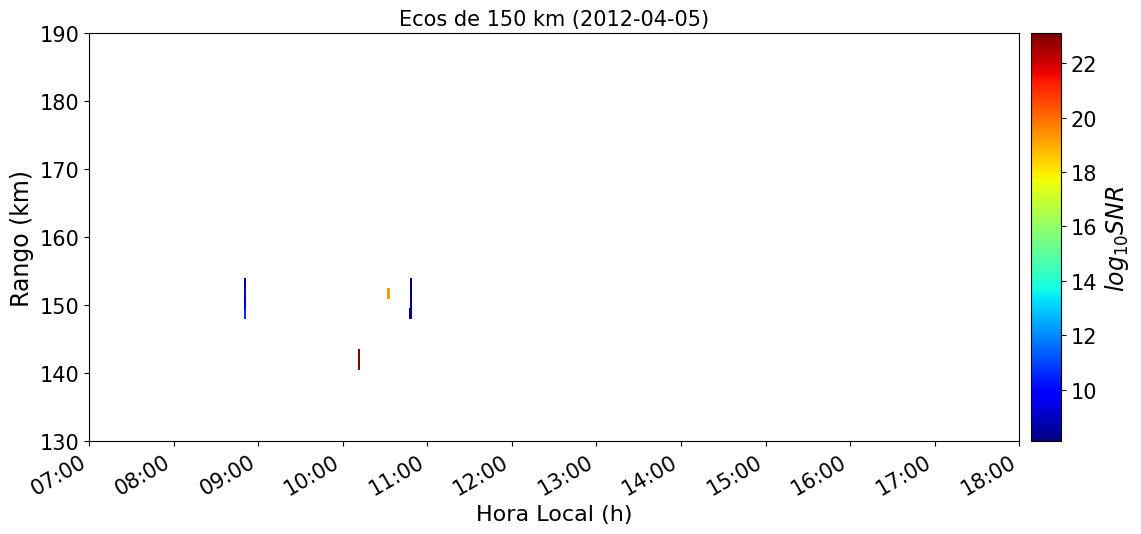

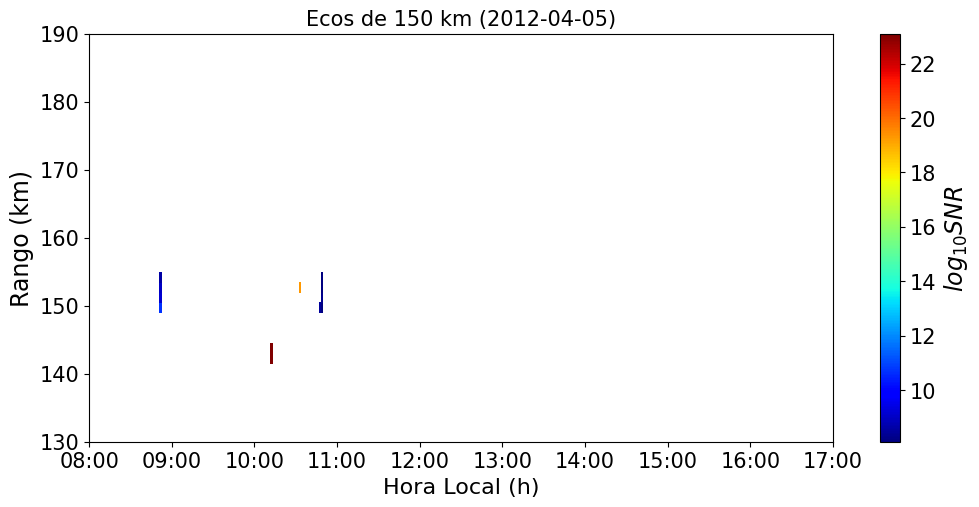

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


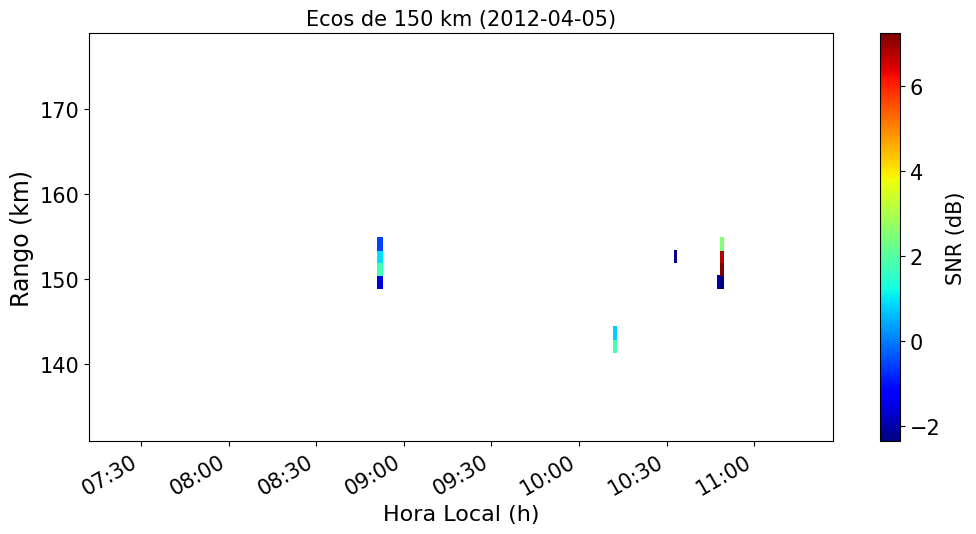

In [40]:
PlotFlag = True
data, index, range_array,dir_plots,datetime_objects, d_prom, range_fixed, time_range, v_vertical,v_prom = GetMatrix(directory, filename1, PlotFlag, plot_format, intFactor)
#directory, filename, PlotFlag, plot_format

jul20120414_150km.001.hdf5
vvert corregido:  (1105,)
0:01:00
time_range.shape:  (720,)
Dimensiones:  (165,) (17,) (165, 17)
(720,) (40,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: Mean of empty slice


Shapes:  (720,) (40,) (40, 720)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


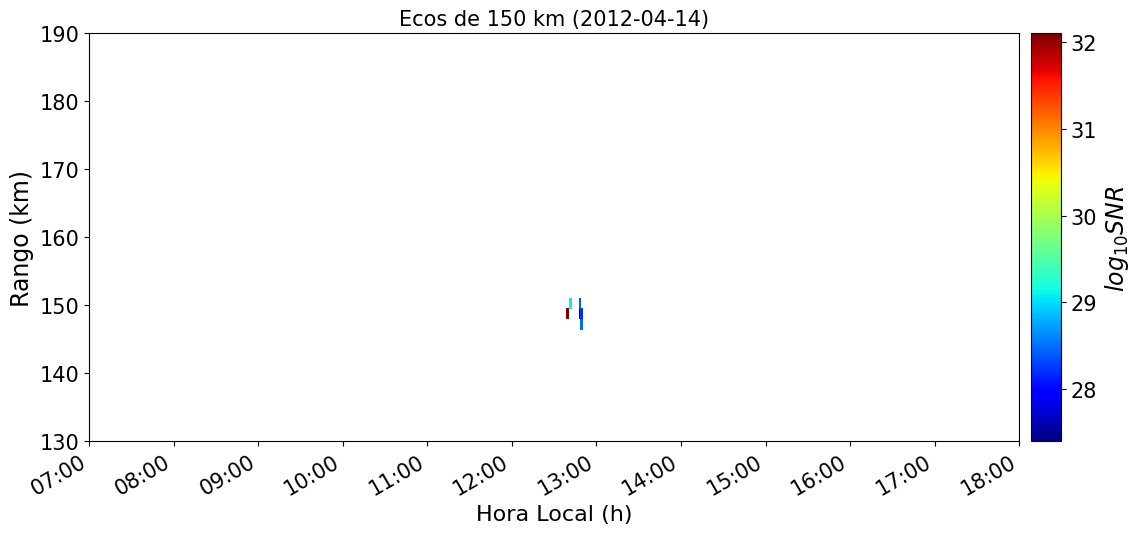

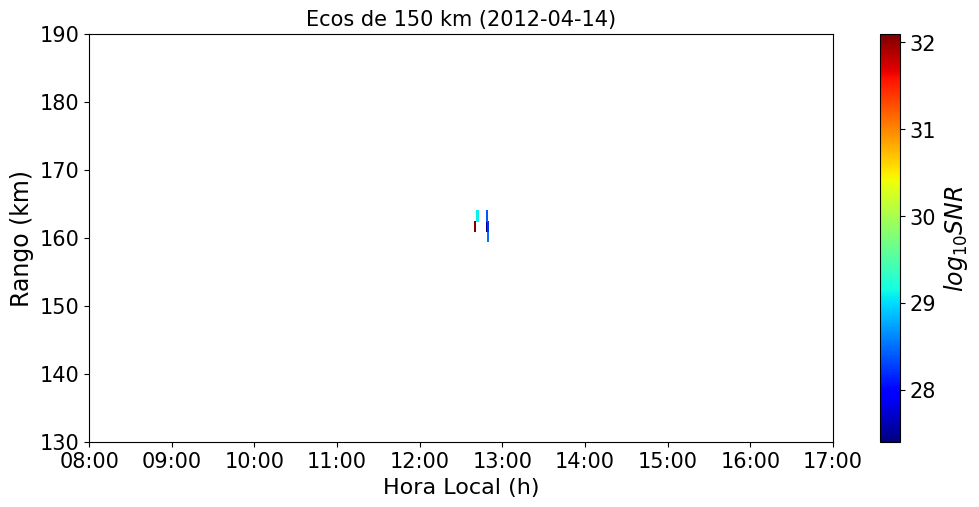

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


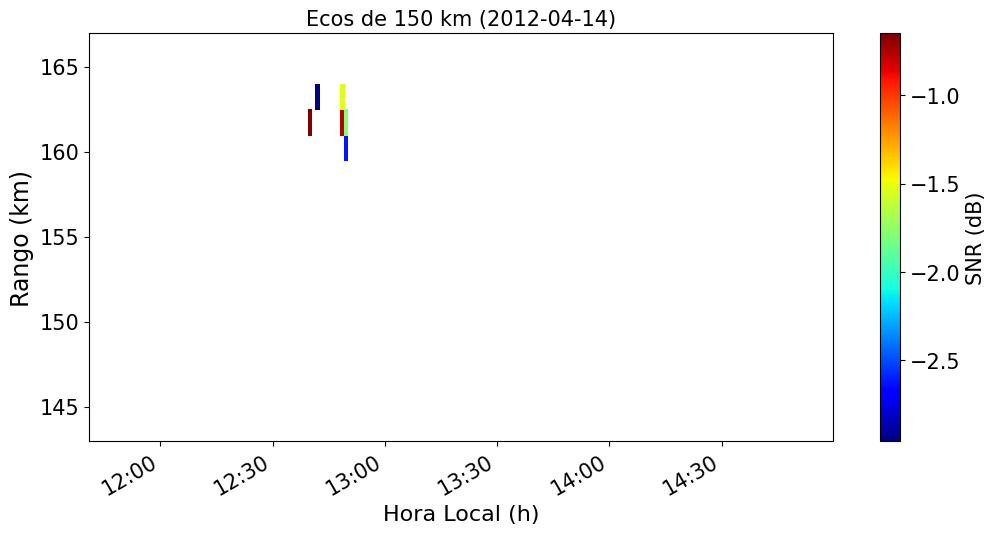

v_vertical.shape:  (17, 165) (720, 40)
jul20120405_150km.001.hdf5
vvert corregido:  (1098,)
0:01:00
time_range.shape:  (720,)
Dimensiones:  (137,) (33,) (137, 33)
(720,) (40,)
Shapes:  (720,) (40,) (40, 720)


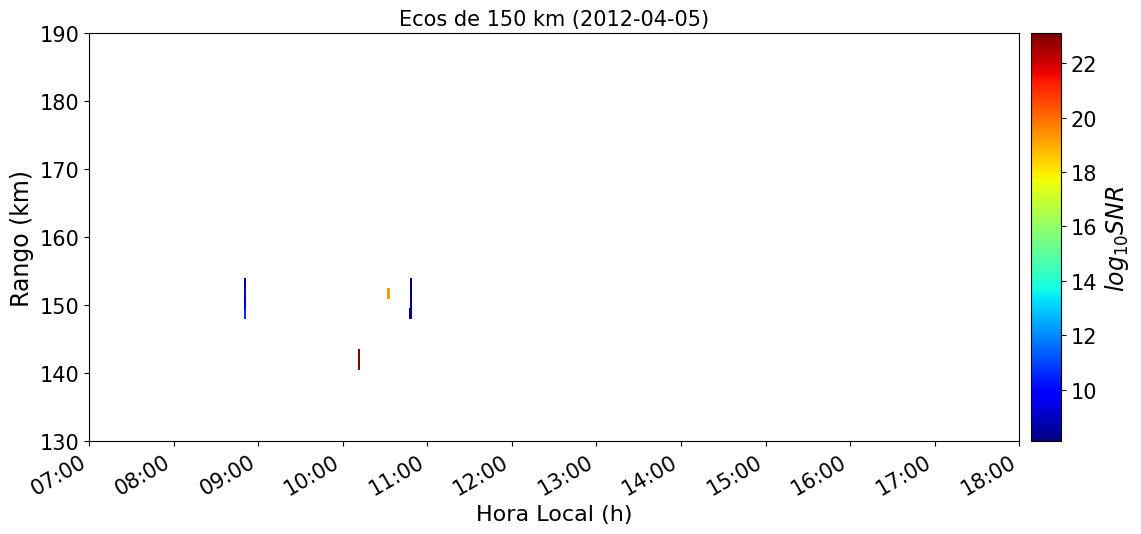

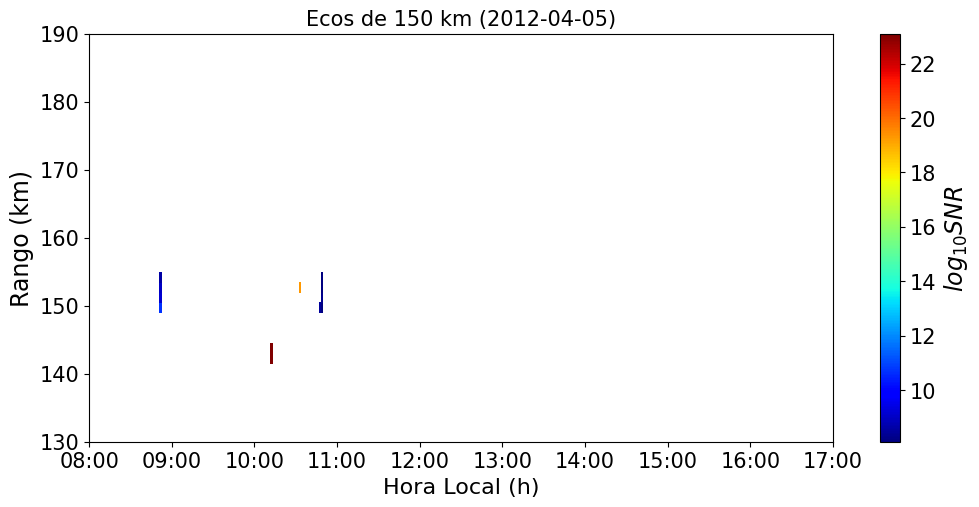

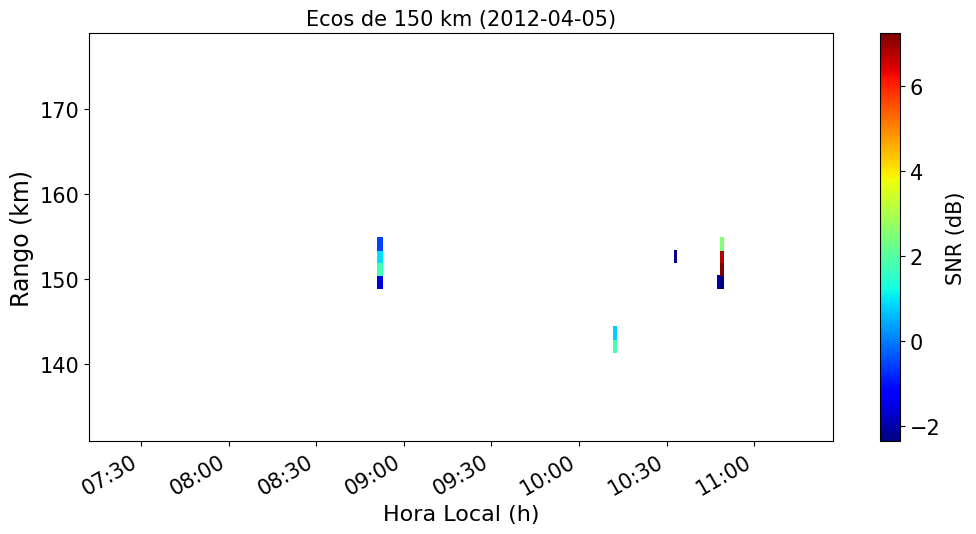

v_vertical.shape:  (33, 137) (720, 40)
jul20120413_150km.001.hdf5
vvert corregido:  (3029,)
0:01:00
time_range.shape:  (720,)
Dimensiones:  (362,) (32,) (362, 32)
(720,) (40,)
Shapes:  (720,) (40,) (40, 720)


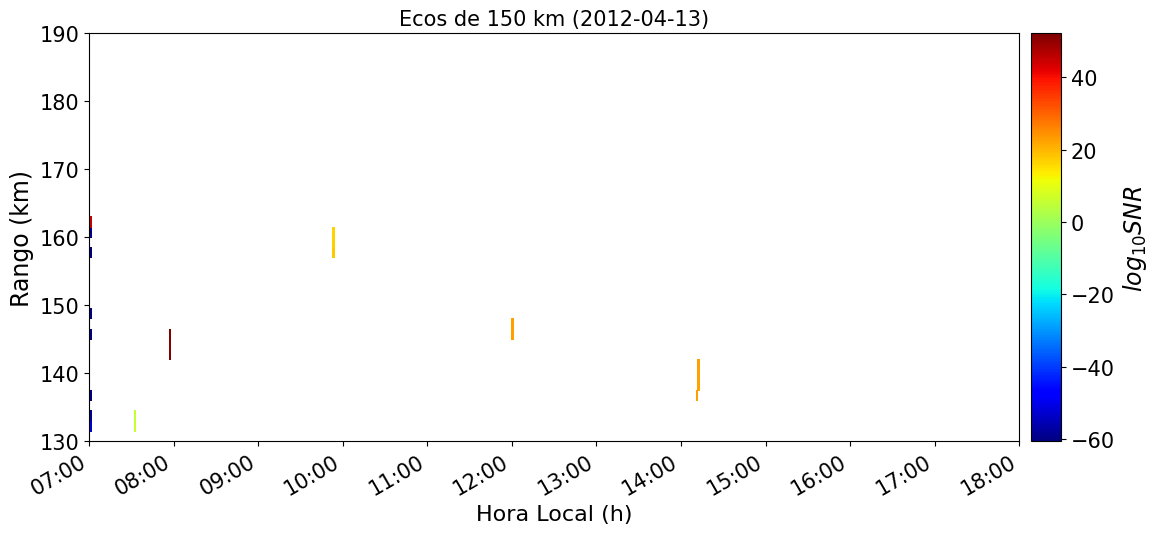

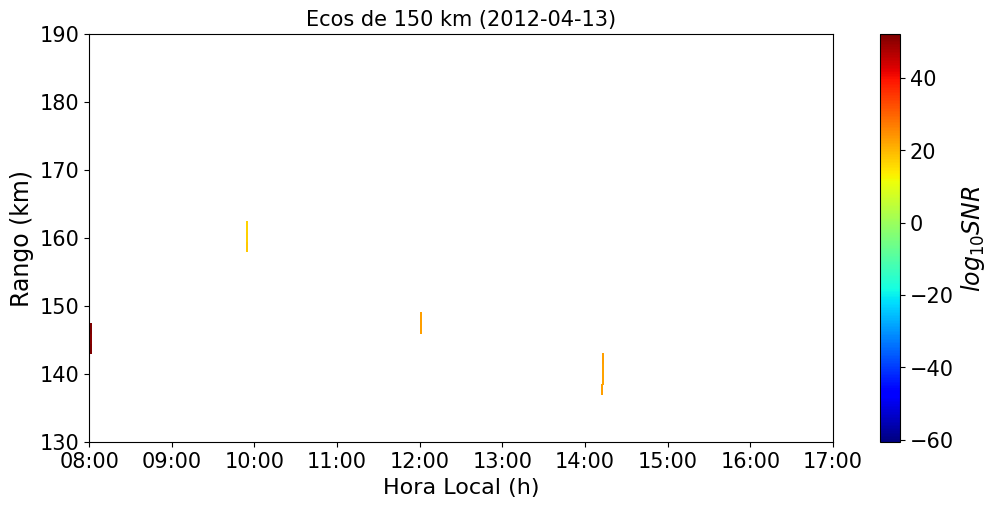

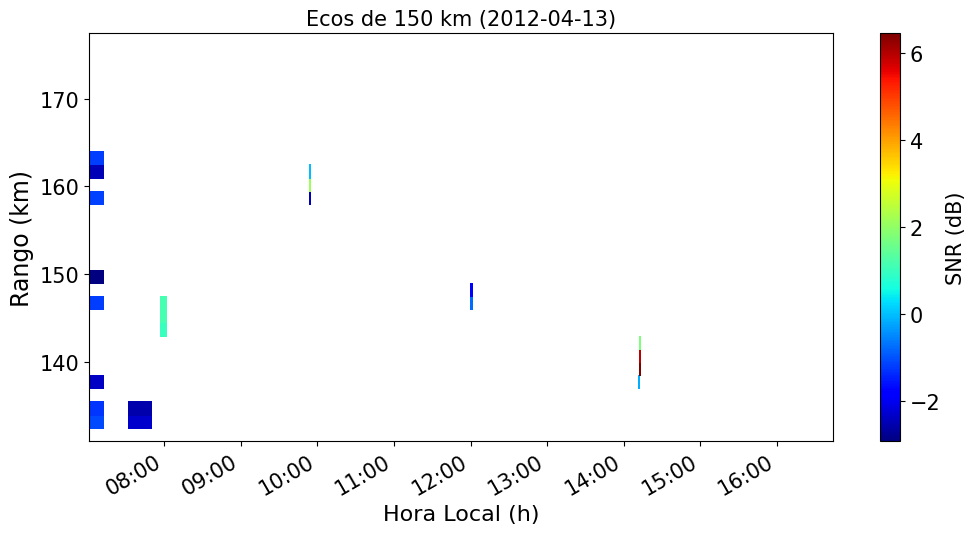

v_vertical.shape:  (32, 362) (720, 40)
jul20120411_150km.001.hdf5
vvert corregido:  (4183,)
0:01:00
time_range.shape:  (720,)
Dimensiones:  (432,) (33,) (432, 33)
(720,) (40,)
Shapes:  (720,) (40,) (40, 720)


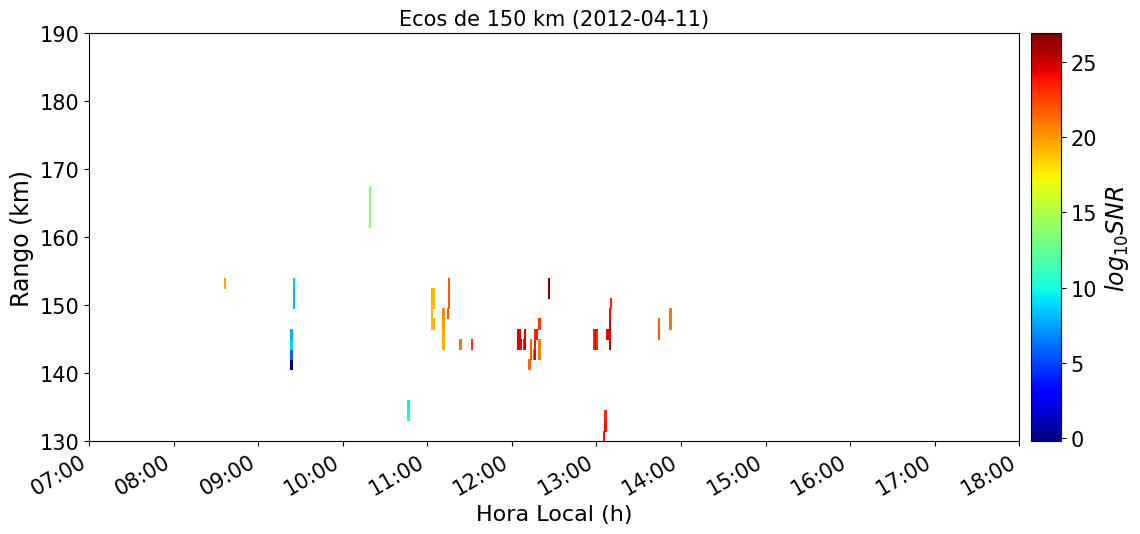

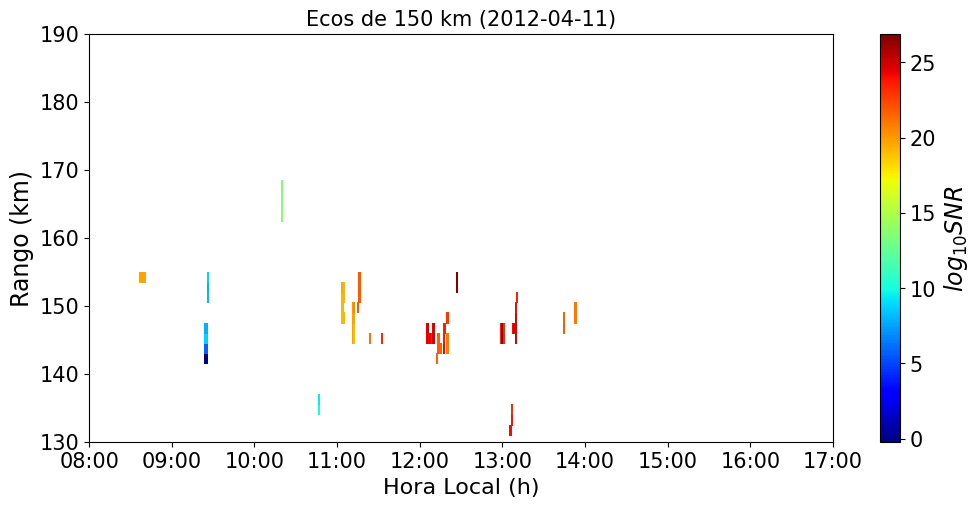

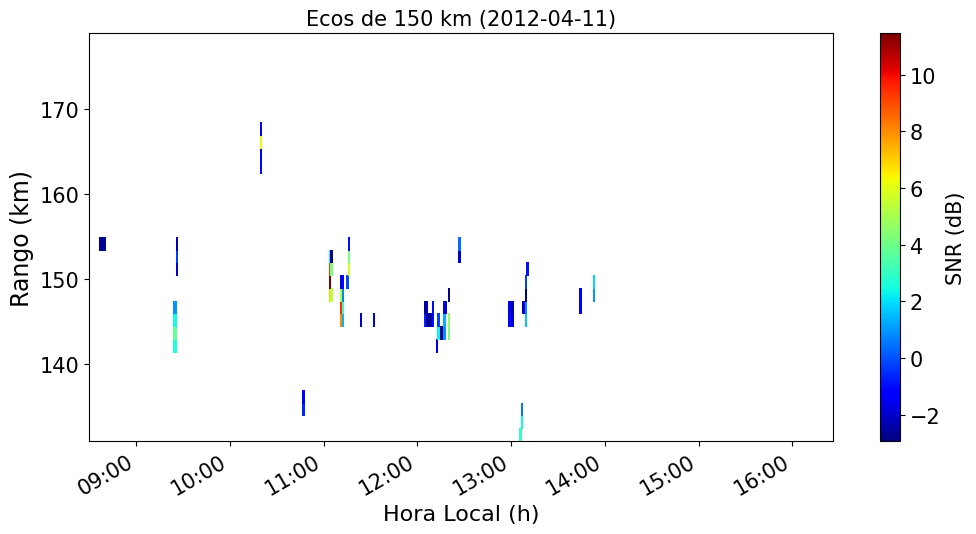

v_vertical.shape:  (33, 432) (720, 40)
jul20120412_150km.001.hdf5
vvert corregido:  (1123,)
0:01:00
time_range.shape:  (720,)
Dimensiones:  (146,) (18,) (146, 18)
(720,) (40,)
Shapes:  (720,) (40,) (40, 720)


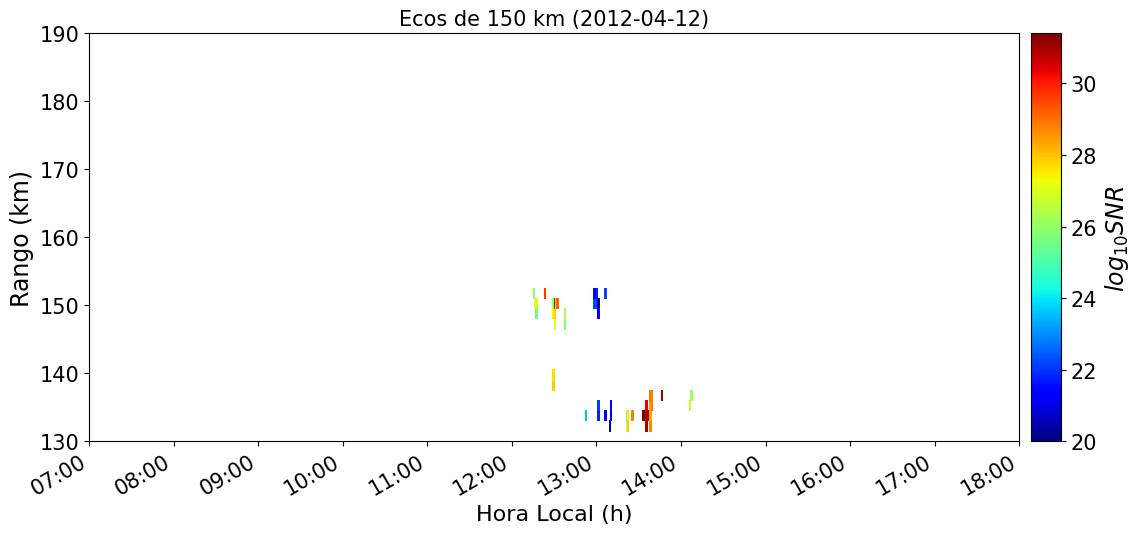

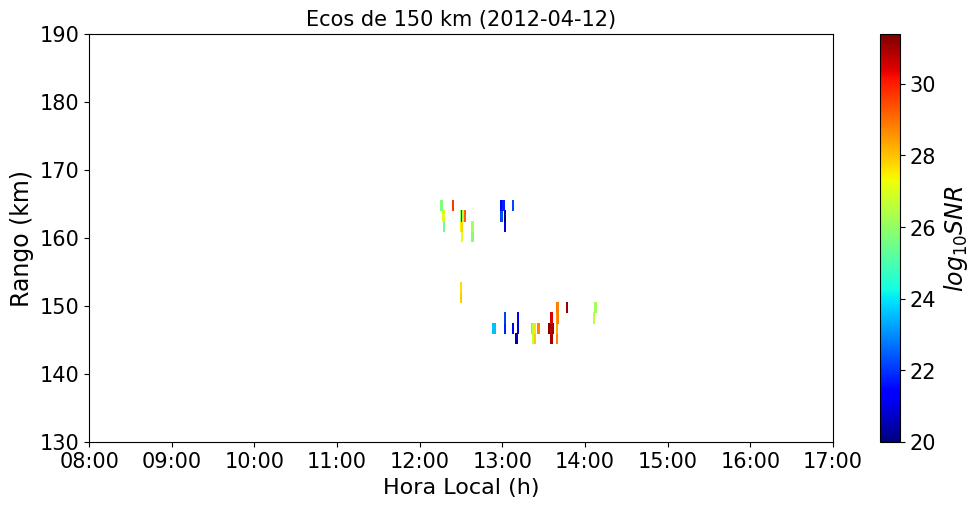

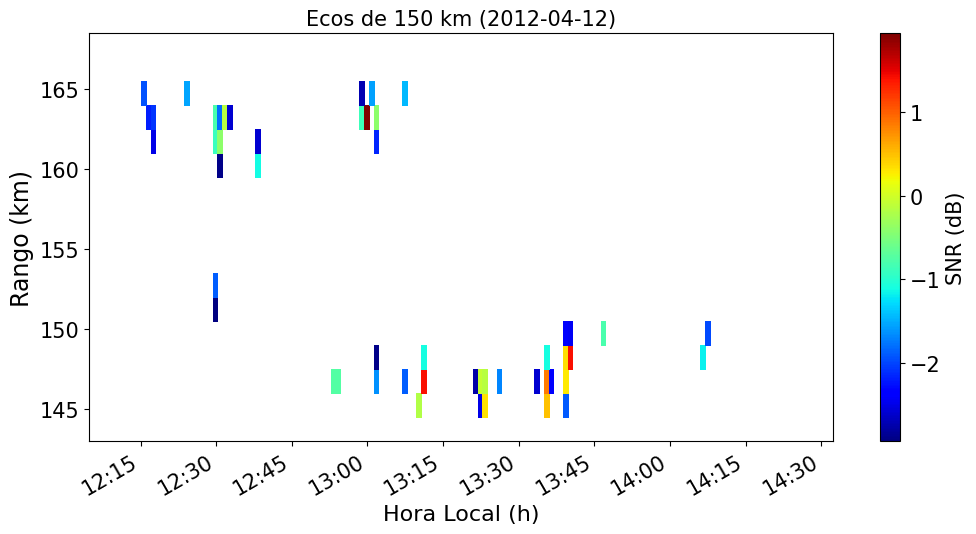

v_vertical.shape:  (18, 146) (720, 40)
jul20120404_150km.001.hdf5
vvert corregido:  (2040,)
0:01:00
time_range.shape:  (720,)
Dimensiones:  (272,) (20,) (272, 20)
(720,) (40,)
Shapes:  (720,) (40,) (40, 720)


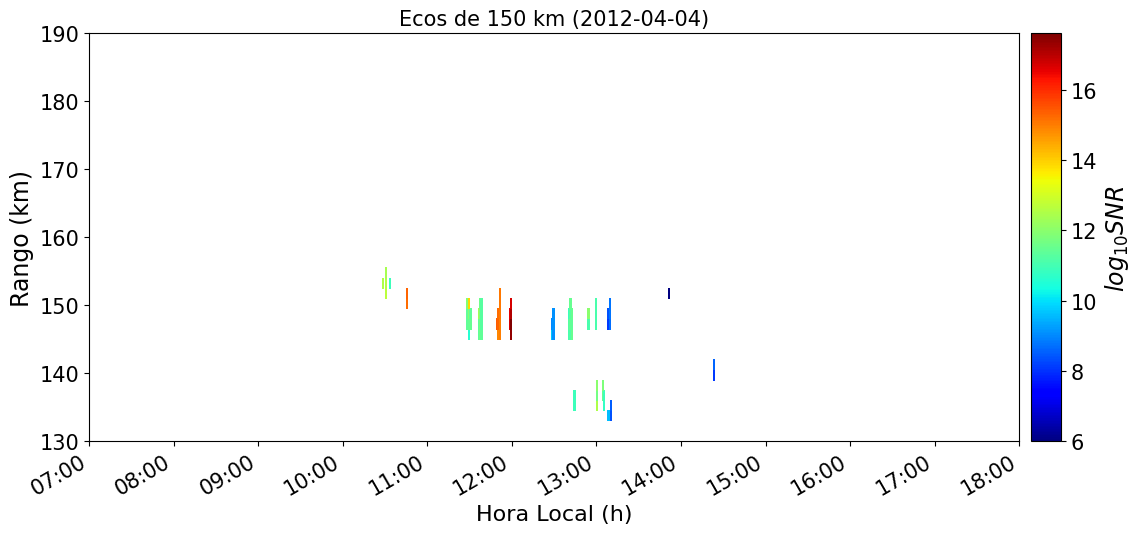

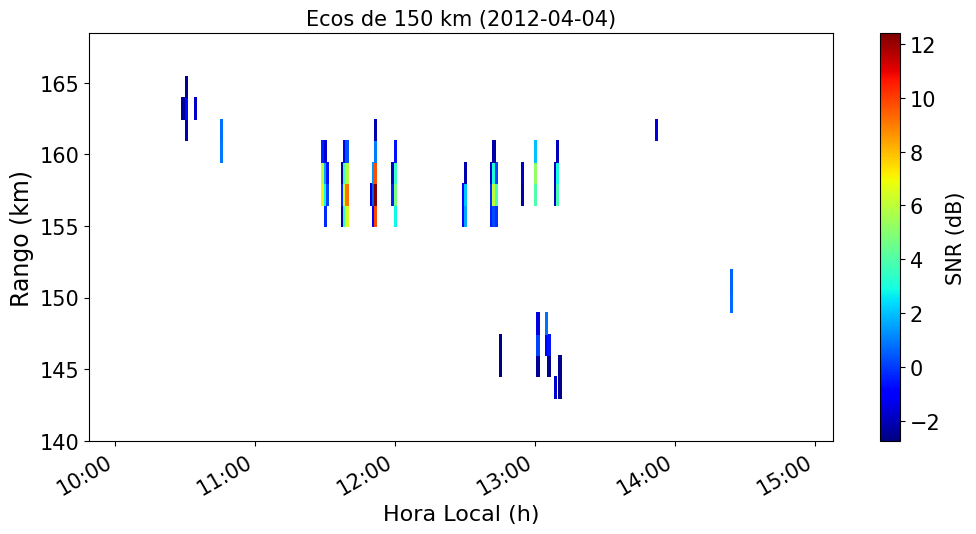

v_vertical.shape:  (20, 272) (720, 40)
jul20120415_150km.001.hdf5
vvert corregido:  (1815,)
0:01:00
time_range.shape:  (720,)
Dimensiones:  (248,) (24,) (248, 24)
(720,) (40,)
Shapes:  (720,) (40,) (40, 720)


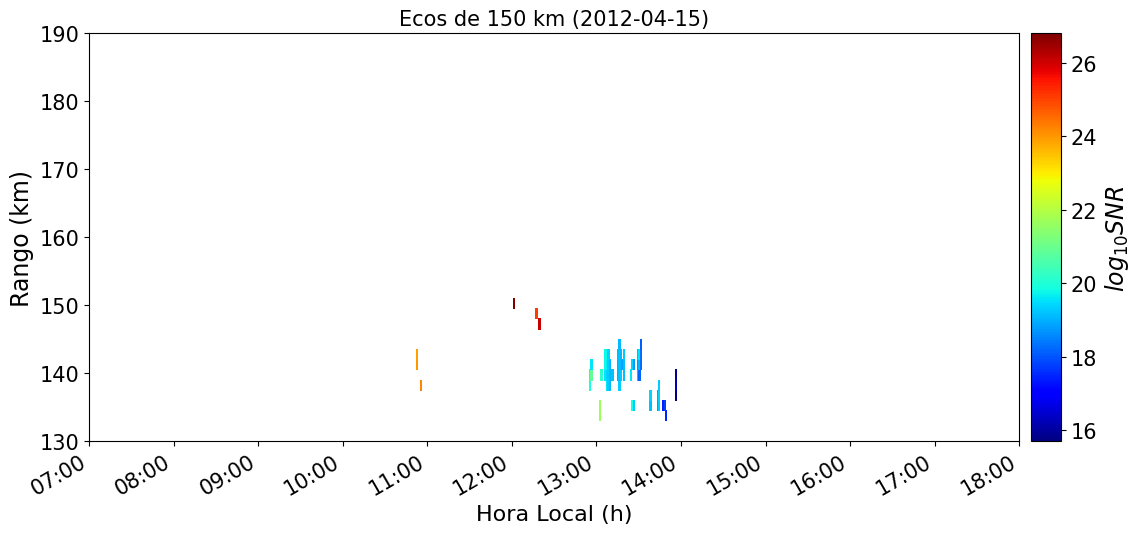

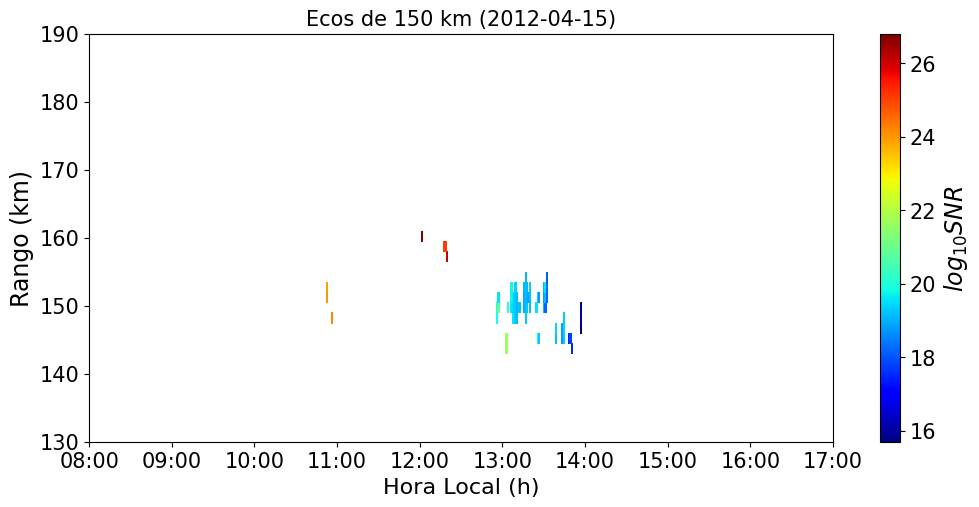

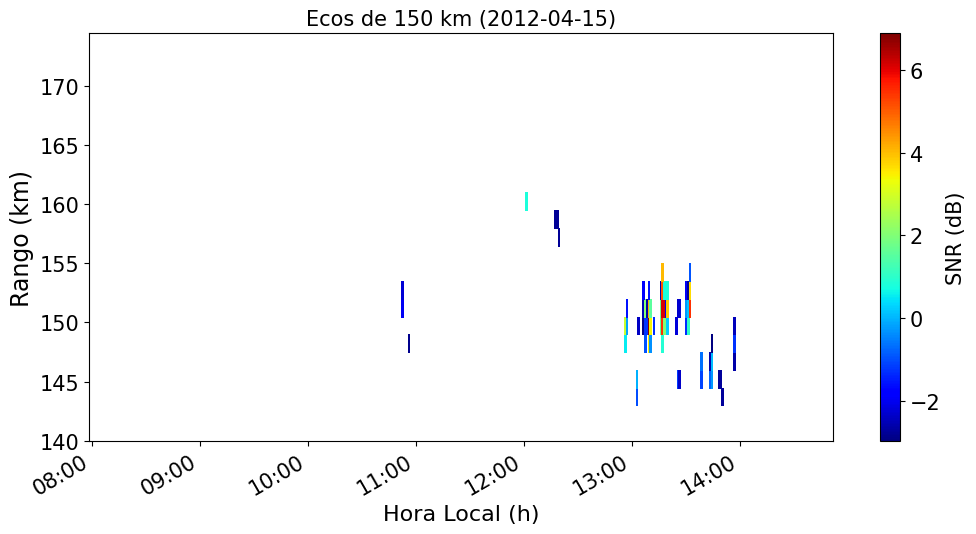

v_vertical.shape:  (19, 248) (720, 40)
jul20120408_150km.001.hdf5
vvert corregido:  (1394,)
0:01:00
time_range.shape:  (720,)
Dimensiones:  (221,) (23,) (221, 23)
(720,) (40,)
Shapes:  (720,) (40,) (40, 720)


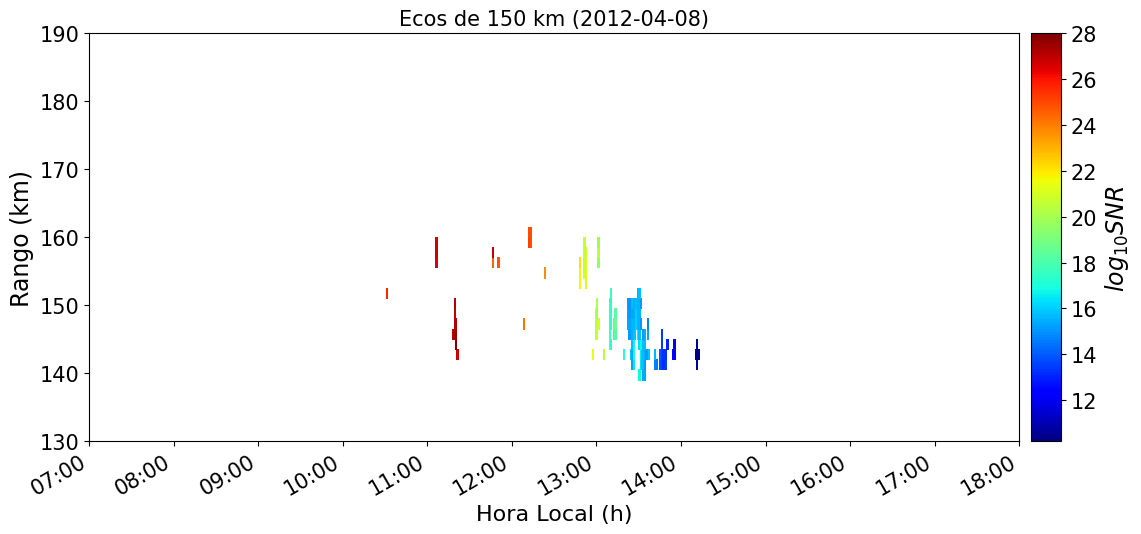

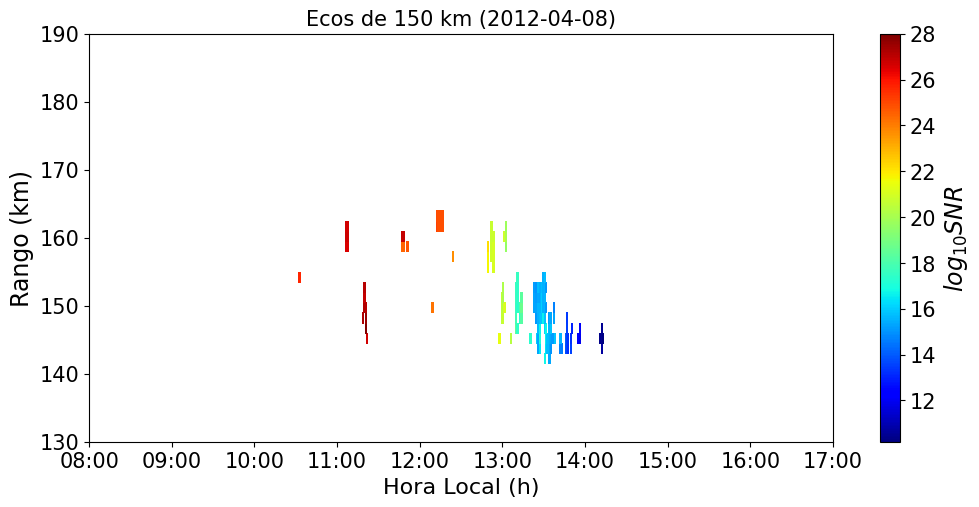

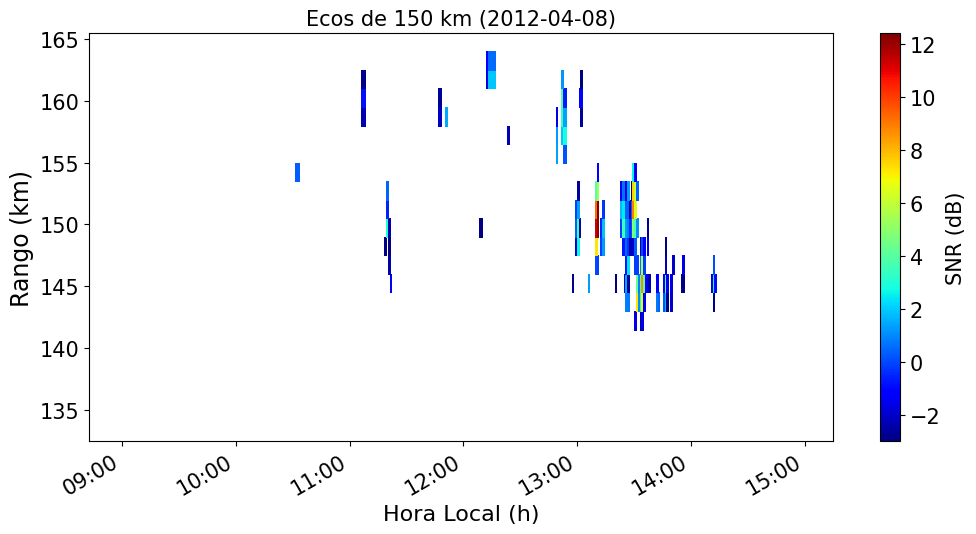

v_vertical.shape:  (21, 221) (720, 40)


In [41]:
mat_avg = np.zeros((int(720/intFactor), 40))
mat_drifts = np.zeros((int(720/intFactor), 40))
#mat_avg = np.zeros((72, 40))
#mat_drifts = np.zeros((72, 40))
counter = 0
#counter = np.zeros((78, 245))
PlotFlag = True
#plot_format= ''
array_list = []
for filename2 in os.listdir(directory):
    if filename2.endswith(".hdf5"):
        print('========================================================')
        print(filename2)
        #data , snl2, snl, index, range_array, rango, dir_plots, time_vector = GetMatrix(directory, filename2, PlotFlag)
        data, index, range_array,dir_plots,datetime_objects, d_prom, range_fixed, time_range,v_vertical, v_prom = GetMatrix(directory, filename2, PlotFlag, plot_format,intFactor)
        matBin, matCount = GetBinaryMatrix(d_prom)
        #print(d_prom.shape, data.shape)
        #aux = AddNaN(mat_drifts,v_prom)
        mat_drifts = AddNaN(mat_drifts,v_prom)
        mat_avg = mat_avg + matBin
        counter = counter + 1 #+ matCount
        print("v_vertical.shape: ",v_vertical.shape, v_prom.shape)
        #print(range_array[0], range_array[-1], index[0], index[-1])
        #print("datetime_objects: ", datetime_objects.shape,np.diff(datetime_objects)[0])
        #print(data.shape, len(snl), index.shape, range_array.shape, len(rango),np.diff(range_array)[0])
        #print('========================================================')
        #counter+=1

In [42]:
mat_avg_final=100*mat_avg/counter
mat_drifts = mat_drifts/counter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


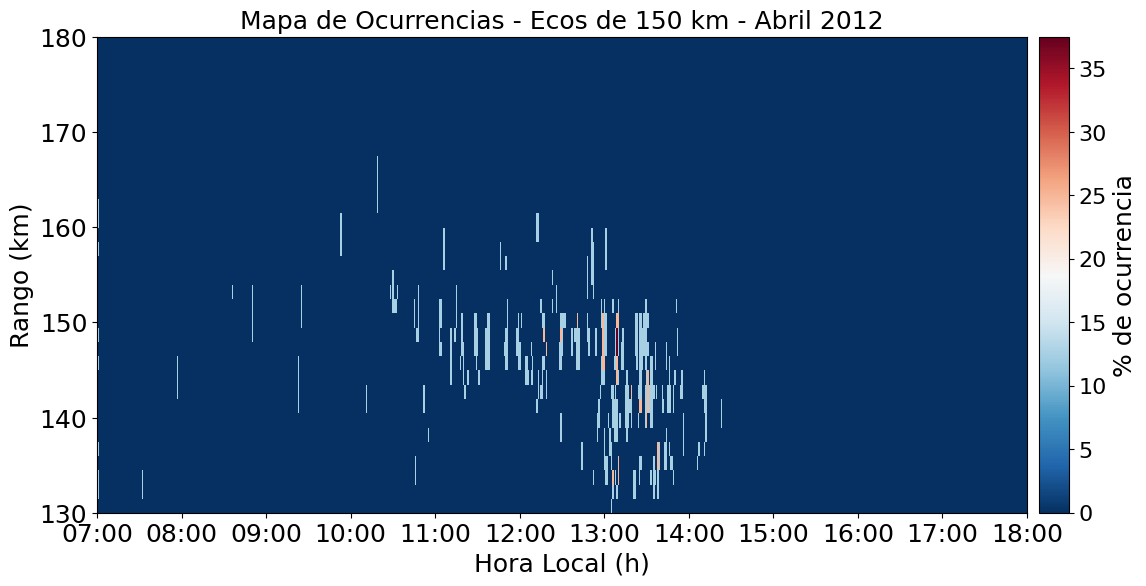

In [43]:
fig, ax = plt.subplots(figsize=(12, 7))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
color_palette = 'RdBu_r'#'Reds'
clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, mat_avg_final.T,cmap=color_palette)#'RdBu_r')#'jet')
linePos1 = datetime.datetime(datetime_objects[0].year,datetime_objects[0].month,datetime_objects[0].day,7,30,0)
linePos2 = datetime.datetime(datetime_objects[0].year,datetime_objects[0].month,datetime_objects[0].day,10,30,0)        
#plt.axvline(x=linePos2,color='black')
#plt.axvline(x=linePos1,color='black')

ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
'''
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
'''
#ax.tick_params(axis='x', rotation=0)
#ax.tick_params(axis='y', rotation=0)
ax.set_xlabel("Hora Local (h)", fontsize=18)
ax.set_ylabel("Rango (km)", fontsize=18)
ax.set_ylim([130,180])
#dia = dia - 1
#ax.xticks(fontsize=14, rotation=90)

str_ti = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,7)
str_tf = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,18)
dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
#fig_title = r'Mapa de Ocurrencias - Ecos de 150 km - %s' % str_month #% (year, month, day) 
fig_title = r'Mapa de Ocurrencias - Ecos de 150 km - %s %d' % (str_month,year) #% (year, month, day) 

plt.title(fig_title, fontsize=18)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.mappable.set_clim(0,np.max(mat_avg_final))
    #cb2 = fig.colorbar(im2)
cb.set_label(r'% de ocurrencia', fontsize=18)
cb.ax.tick_params(labelsize=16)
cb.mappable.set_clim(0,np.max(mat_avg_final))

plot_format = 'png'
str_fig = '%s/filtered-%dmin-mapa-de-ocurrencias-Ecos-de-150km%d-%s-%s.%s' % (plots_boletin,intFactor,year, GetMonth(month),color_palette,plot_format)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )
plt.savefig(str_fig,bbox_inches="tight")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


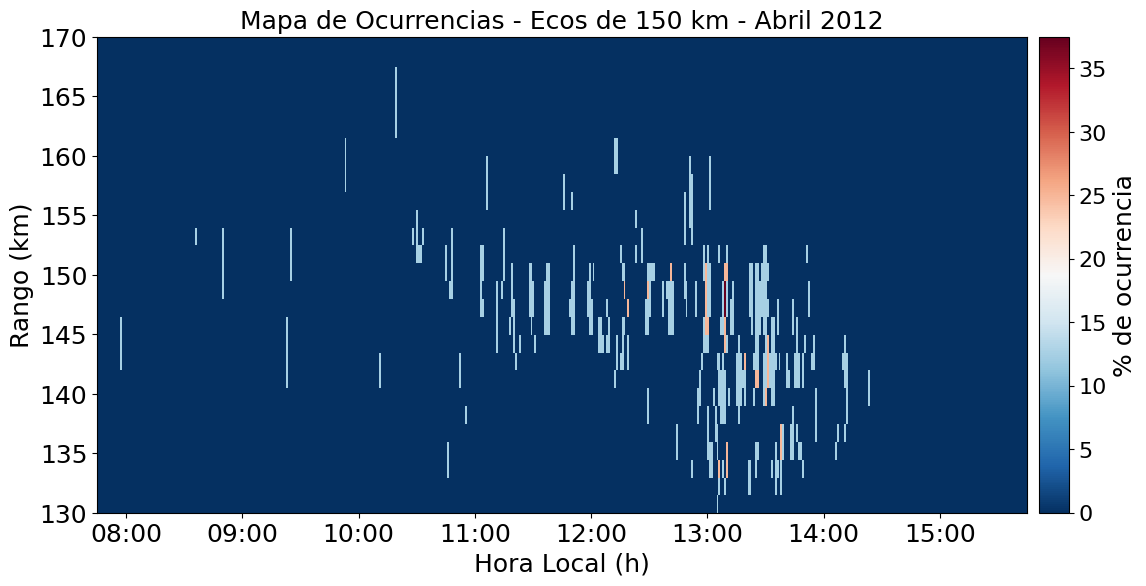

In [44]:
fig, ax = plt.subplots(figsize=(12, 7))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
color_palette = 'RdBu_r'#'Reds'
clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, mat_avg_final.T,cmap=color_palette)#'RdBu_r')#'jet')

ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
'''
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
'''
#ax.tick_params(axis='x', rotation=0)
#ax.tick_params(axis='y', rotation=0)
ax.set_xlabel("Hora Local (h)", fontsize=18)
ax.set_ylabel("Rango (km)", fontsize=18)
ax.set_ylim([130,170])
#dia = dia - 1
#ax.xticks(fontsize=14, rotation=90)

str_ti = '%d-%02d-%02d %02d:%02d:00' % (time_range[0].year,time_range[0].month,time_range[0].day,7,45)
str_tf = '%d-%02d-%02d %02d:%02d:00' % (time_range[0].year,time_range[0].month,time_range[0].day,15,45)
dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
#fig_title = r'Mapa de Ocurrencias - Ecos de 150 km' #% (year, month, day) 
#fig_title = r'Mapa de Ocurrencias - Ecos de 150 km - %s' % str_month #% (year, month, day) 
fig_title = r'Mapa de Ocurrencias - Ecos de 150 km - %s %d' % (str_month, year) #% (year, month, day) 

plt.title(fig_title, fontsize=18)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.mappable.set_clim(0,np.max(mat_avg_final))
    #cb2 = fig.colorbar(im2)
cb.set_label(r'% de ocurrencia', fontsize=18)
cb.ax.tick_params(labelsize=16)
cb.mappable.set_clim(0,np.max(mat_avg_final))

plot_format = 'png'
str_fig = '%s/filtered-%dmin-mapa-de-ocurrencias-Ecos-de-150km%d-%s-%s.%s' % (plots_boletin,intFactor,year, GetMonth(month),color_palette,plot_format)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )
plt.savefig(str_fig,bbox_inches="tight")

In [45]:
print(np.min(mat_avg_final),np.max(mat_avg_final))

0.0 37.5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


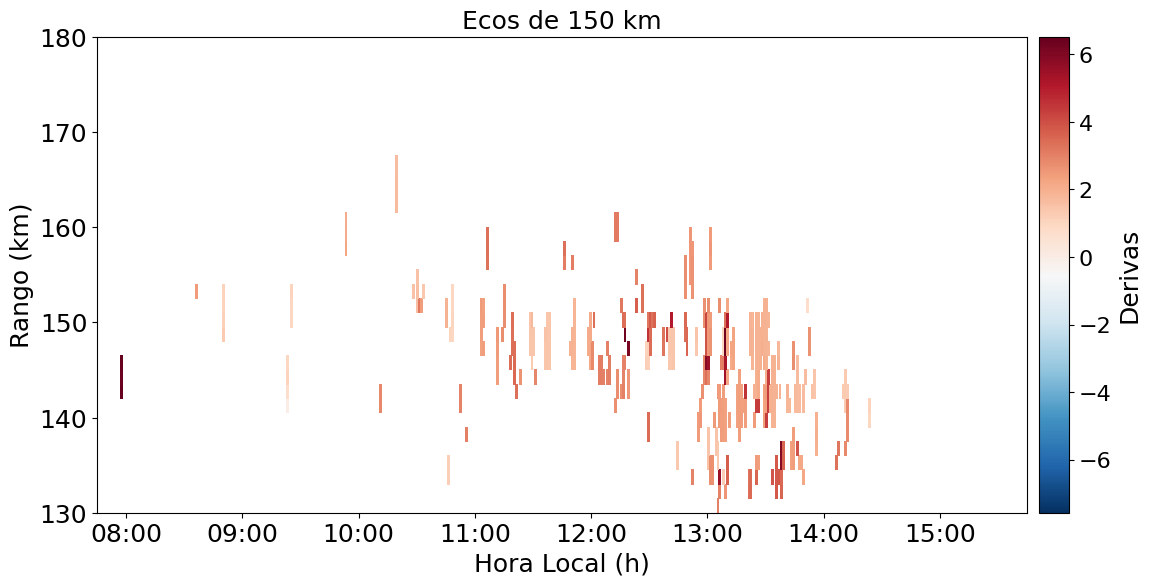

In [46]:
mat_drifts[mat_drifts==0]=np.nan
fig, ax = plt.subplots(figsize=(12, 7))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
color_palette = 'RdBu_r'#'Reds'#'jet'
clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, mat_drifts.T,cmap=color_palette)#'RdBu_r')#'jet')

ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
#ax.tick_params(axis='x', rotation=0)
#ax.tick_params(axis='y', rotation=0)
ax.set_xlabel("Hora Local (h)", fontsize=18)
ax.set_ylabel("Rango (km)", fontsize=18)
ax.set_ylim([130,180])
#str_ti = '2021-03-31 07:00:00'
#str_tf = '2021-03-31 17:00:00'
#dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
#dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
#ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])

#dia = dia - 1
#ax.xticks(fontsize=14, rotation=90)


str_ti = '%d-%02d-%02d %02d:%02d:00' % (time_range[0].year,time_range[0].month,time_range[0].day,7,45)
str_tf = '%d-%02d-%02d %02d:%02d:00' % (time_range[0].year,time_range[0].month,time_range[0].day,15,45)
dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
fig_title = r'Ecos de 150 km' #% (year, month, day) 
plt.title(fig_title, fontsize=18)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
#cb.mappable.set_clim(0,100)
    #cb2 = fig.colorbar(im2)
#cb.mappable.set_clim(-20,20)

cb.set_label(r'Derivas', fontsize=18)
cb.ax.tick_params(labelsize=16)
str_fig = 'filtered-rti-promedio-ecos-150km-%d-%s-nuevo-%s' % (year, GetMonth(month),color_palette)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )

plt.savefig(str_fig)

In [47]:
print(mat_avg_final[mat_avg_final>100])
print(time_range[0])


[]
2012-04-08 07:00:00


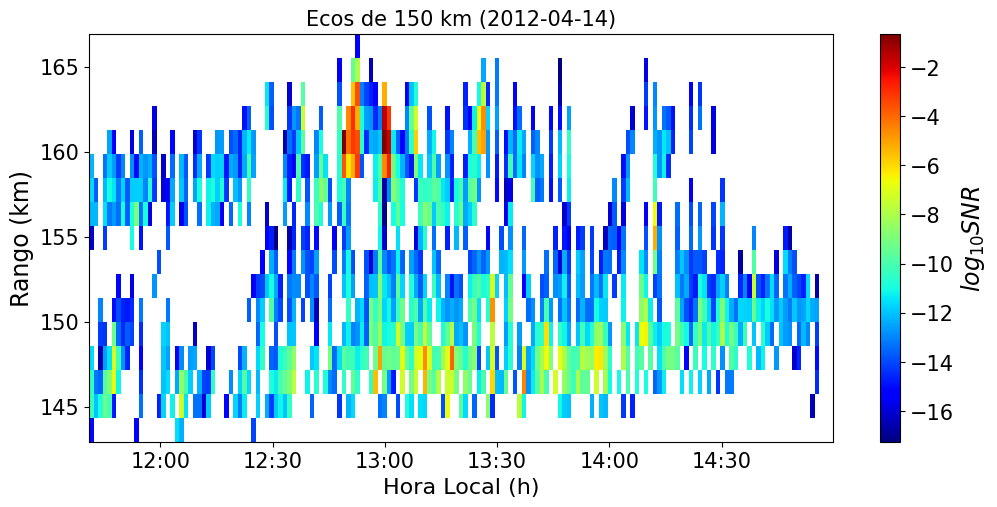

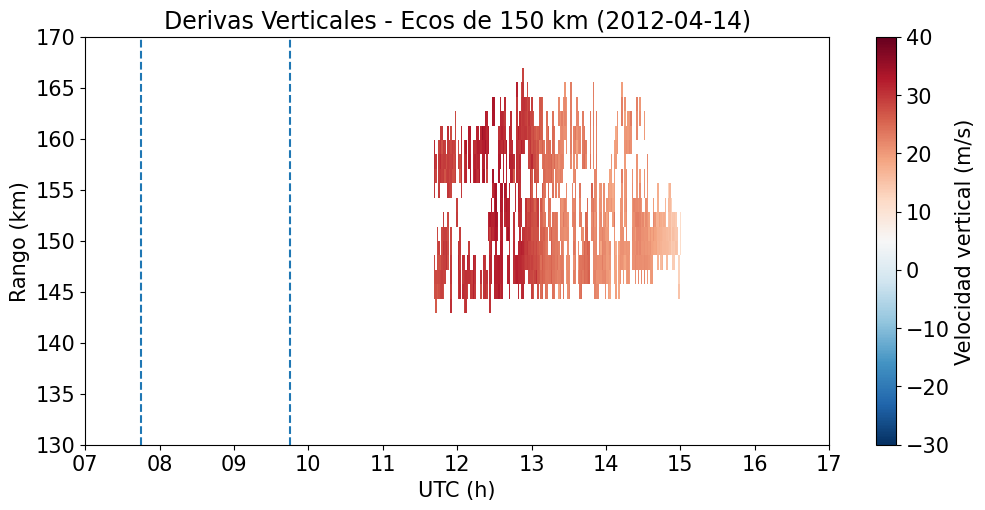

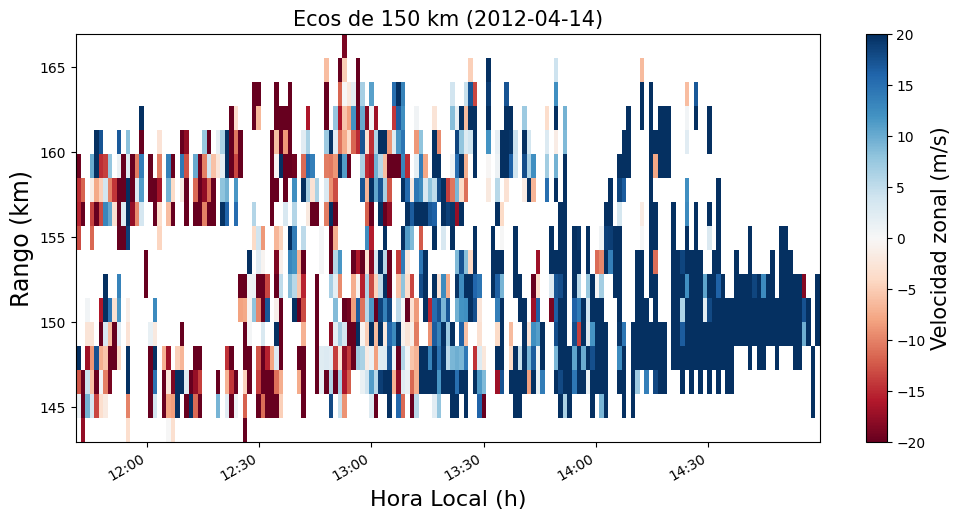

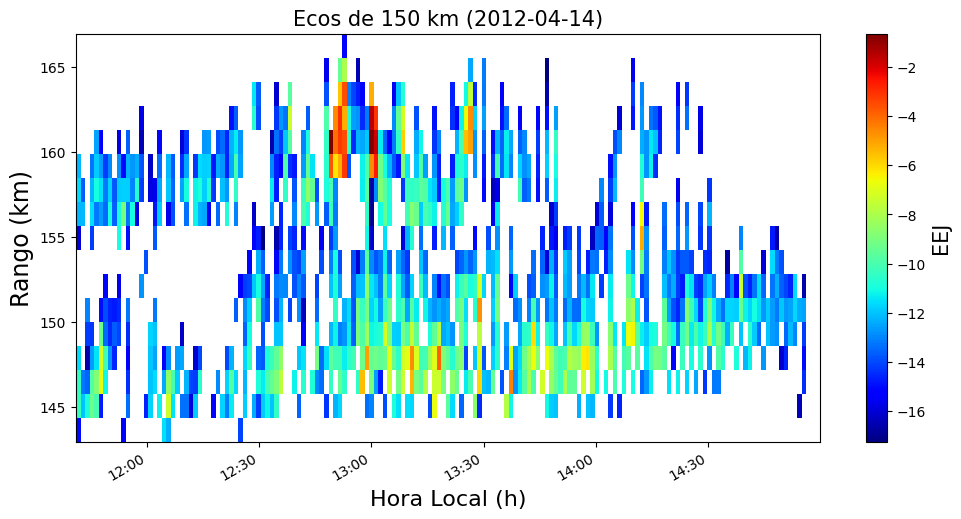

(17, 165) 2012-04-14 11:41:00 2012-04-14 14:59:50 62.0 142.95 166.95 1.5
Rango:  142.95 166.95


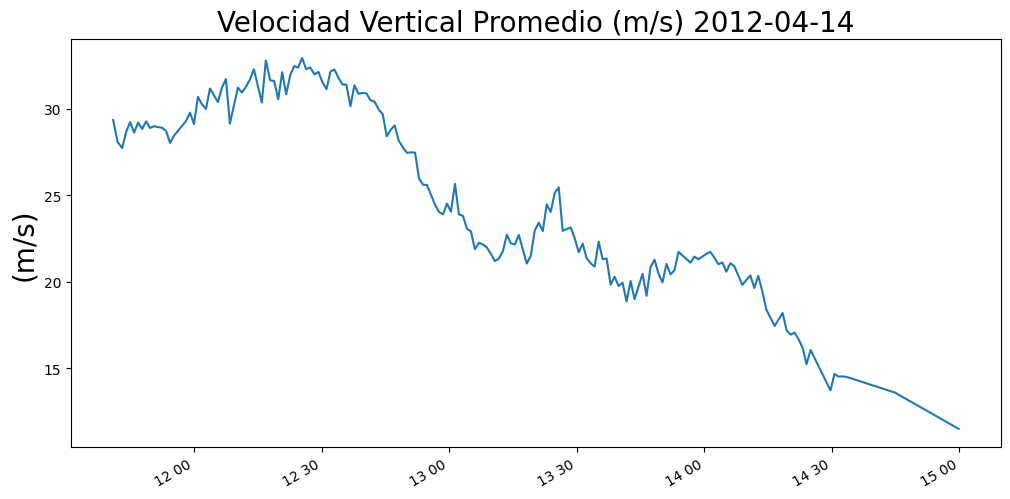

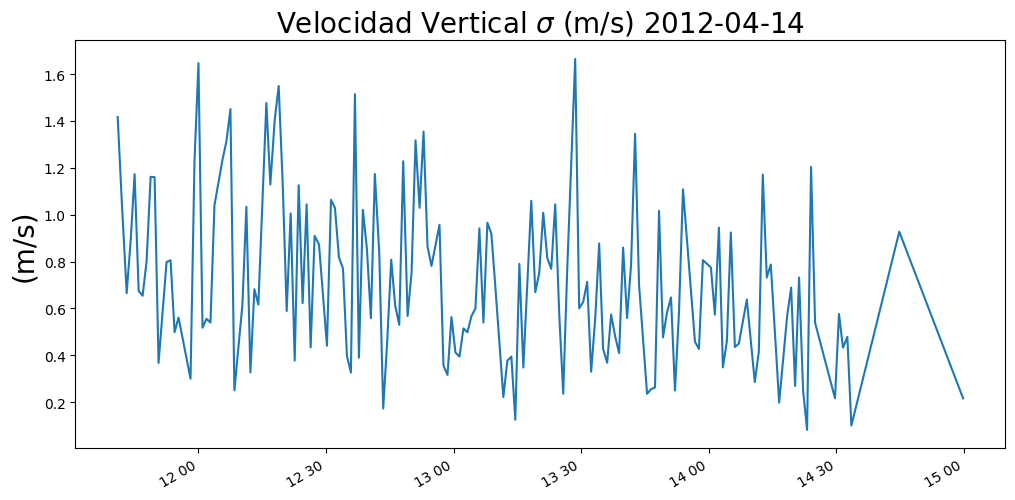

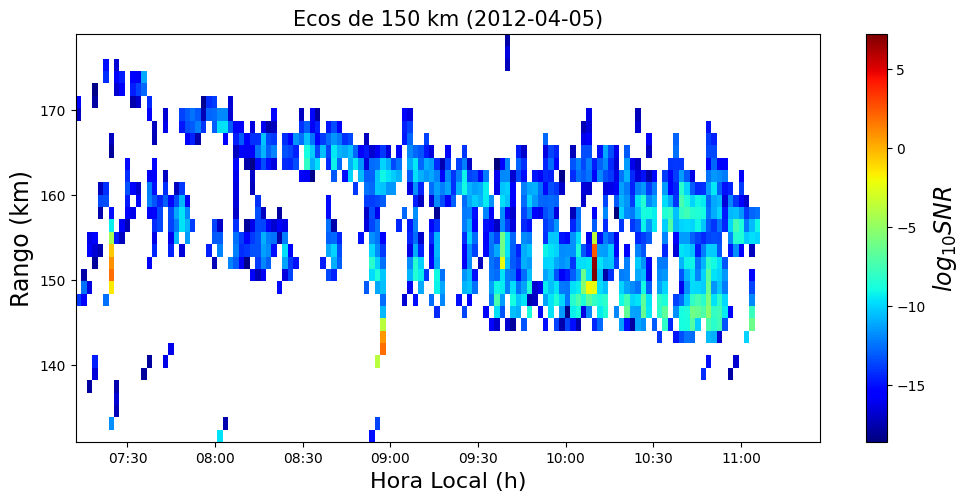

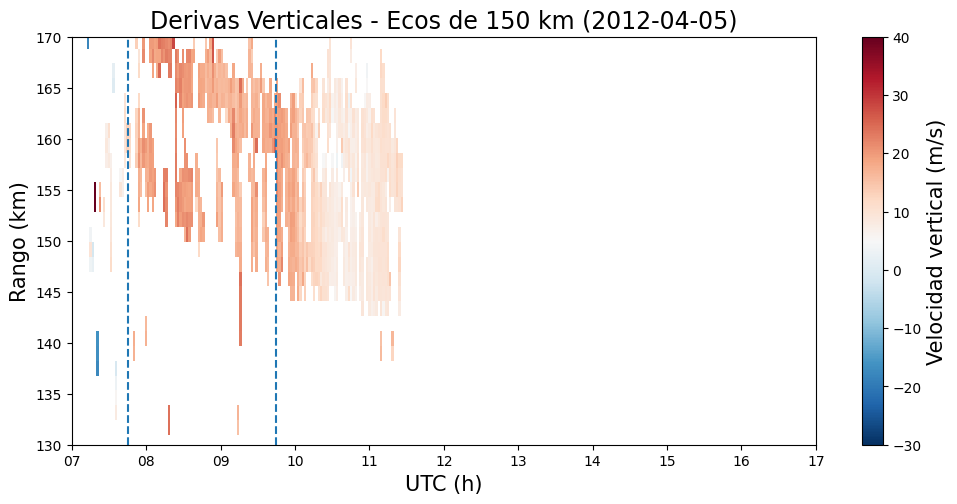

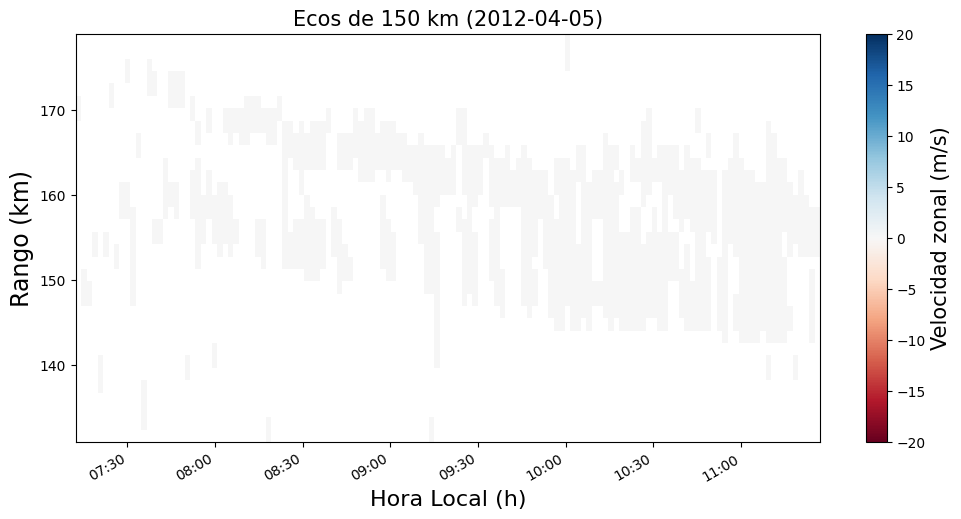

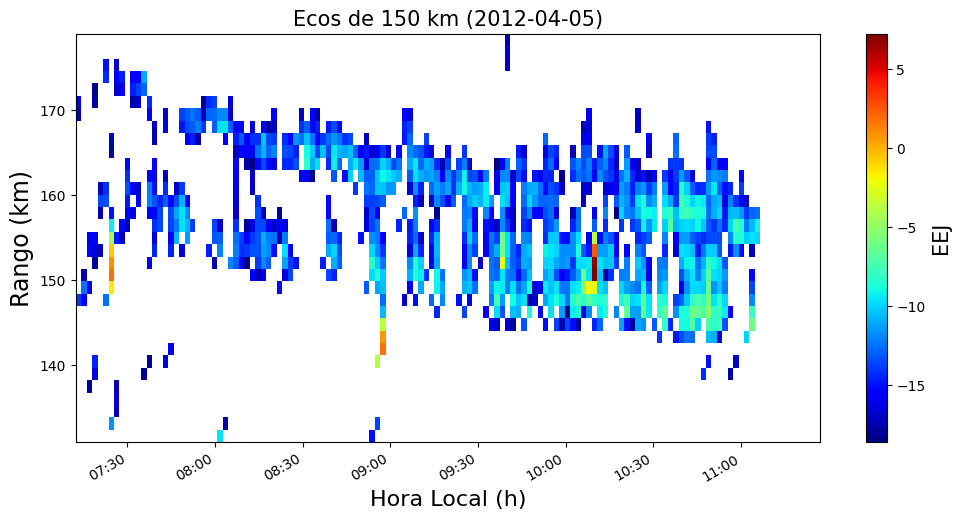

(33, 137) 2012-04-05 07:12:18 2012-04-05 11:26:57 338.0 130.95 178.95 1.5
Rango:  130.95 178.95


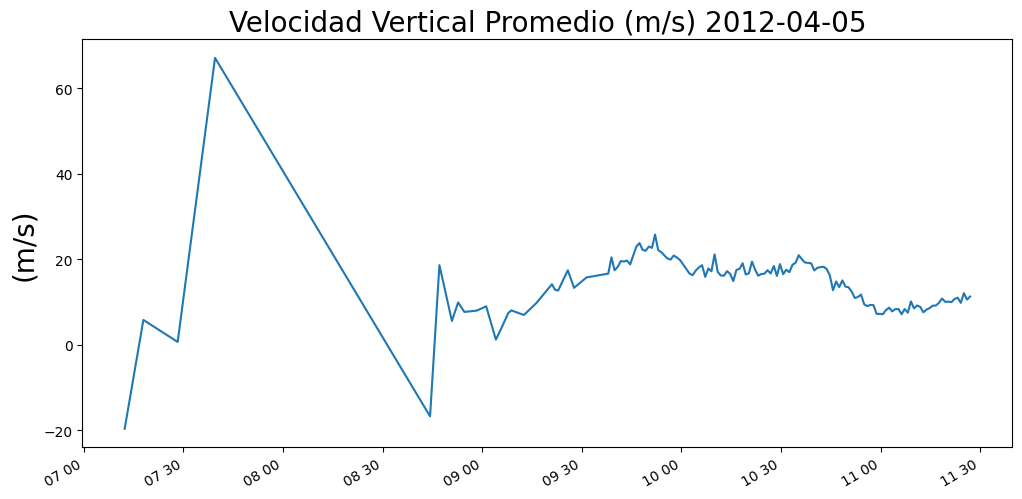

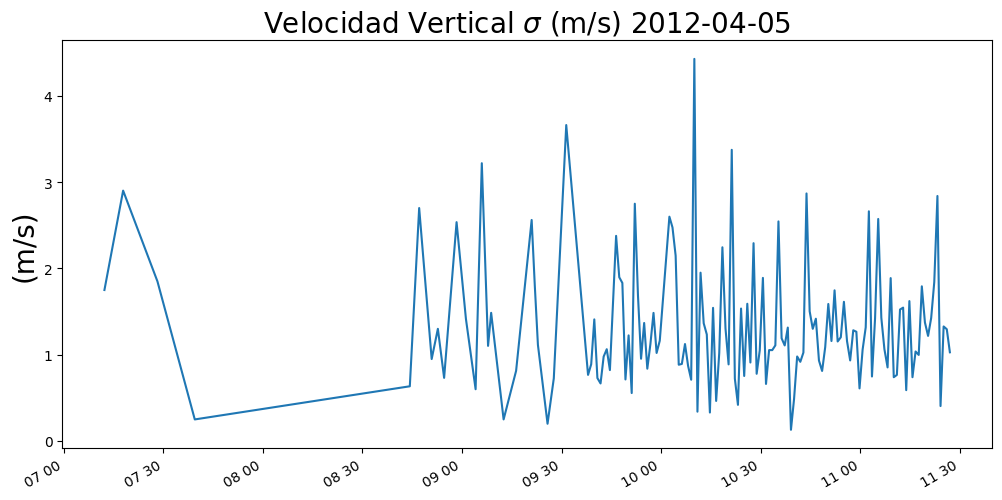

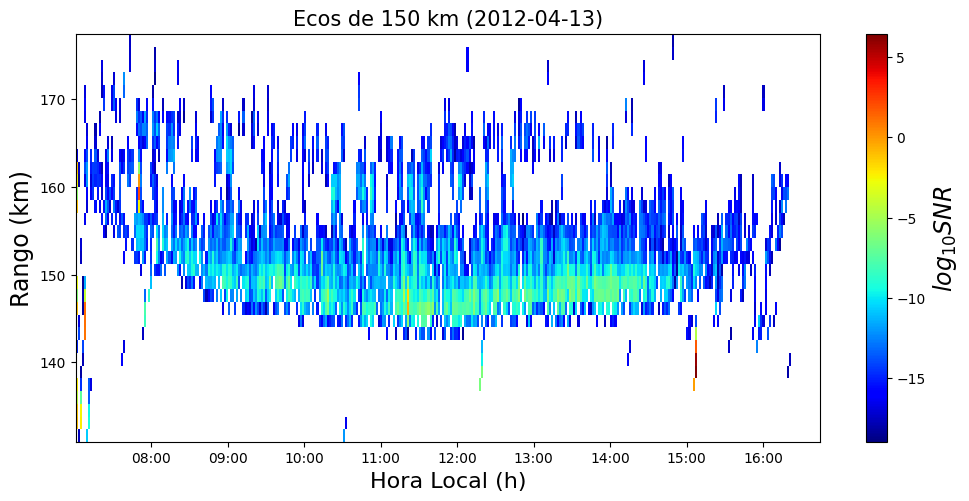

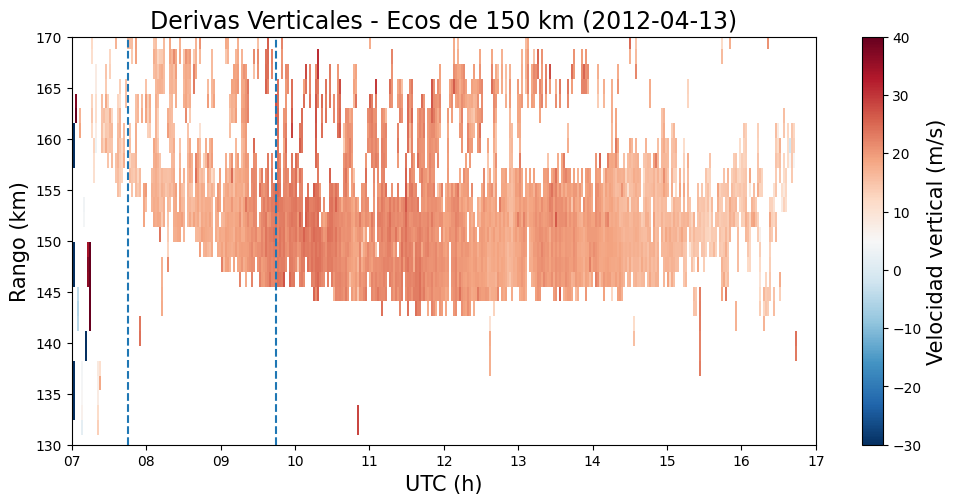

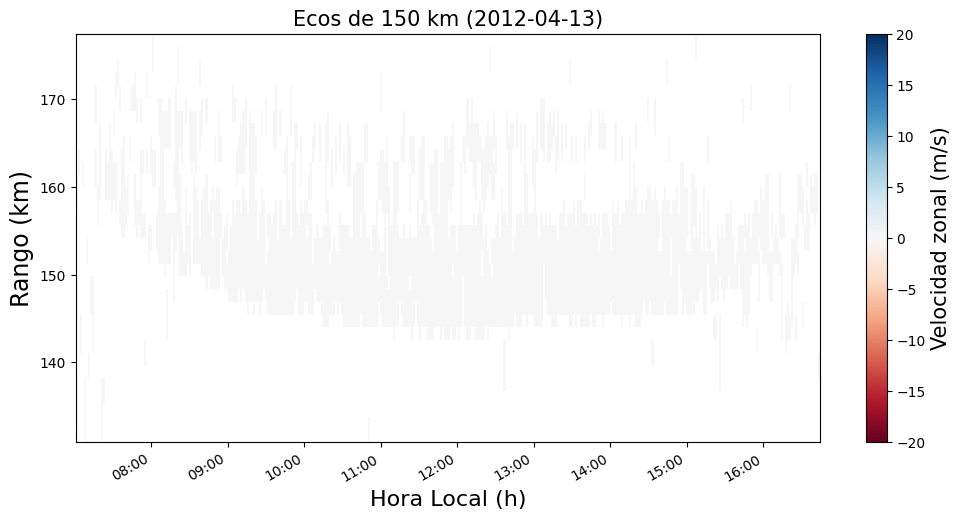

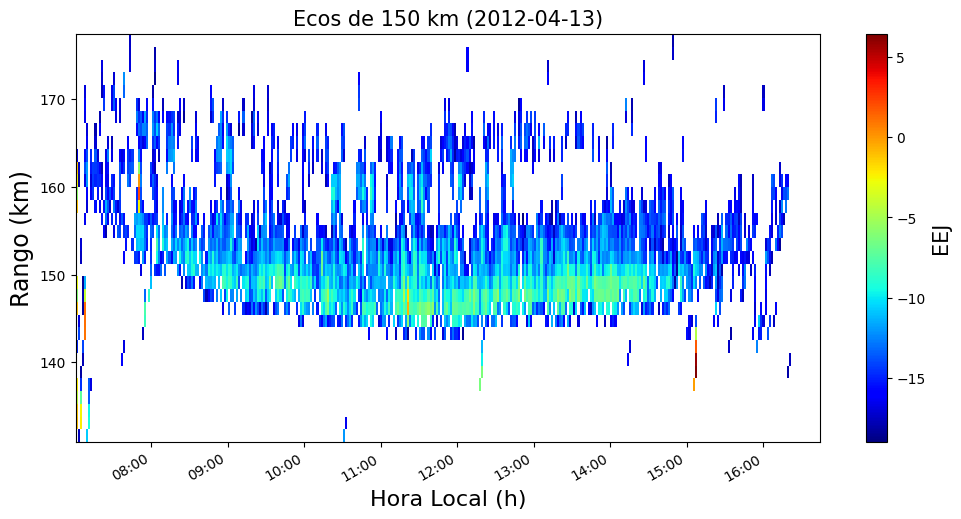

(32, 362) 2012-04-13 07:01:02 2012-04-13 16:44:14 676.0 130.95 177.45 1.5
Rango:  130.95 177.45


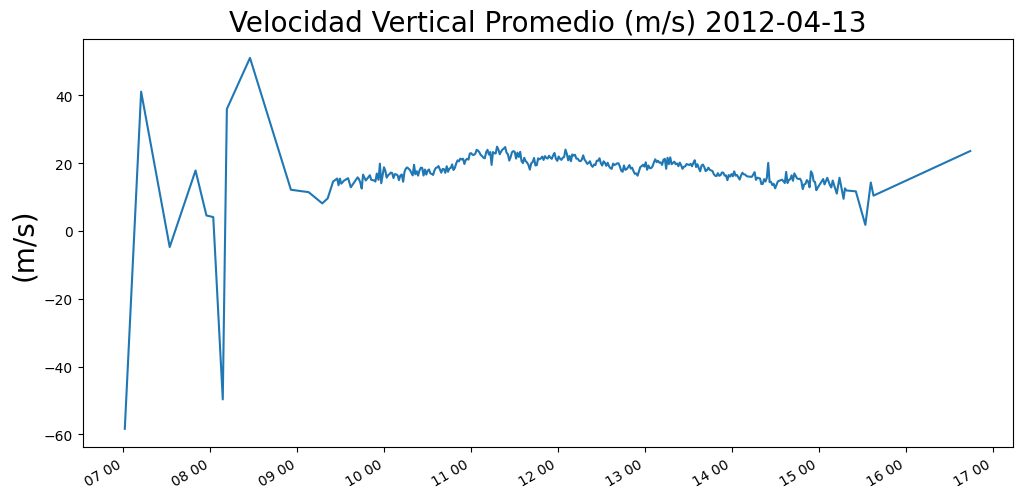

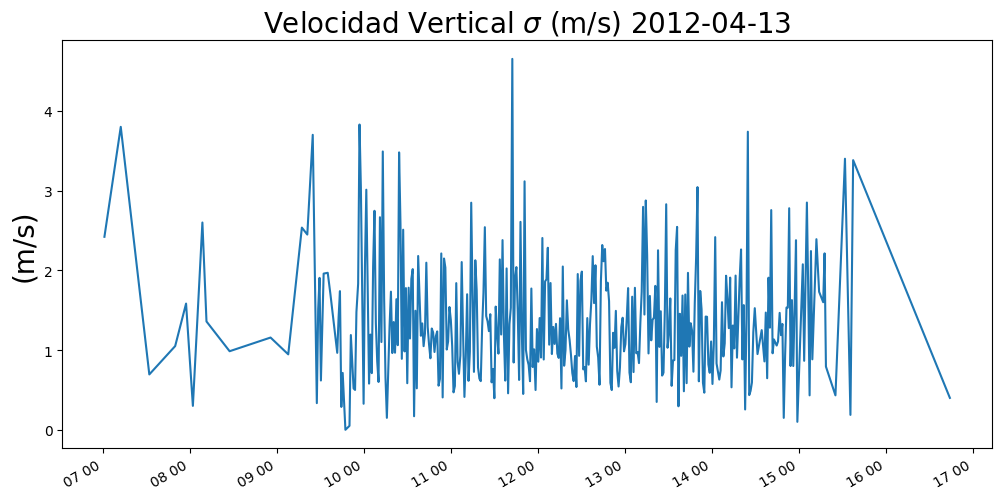

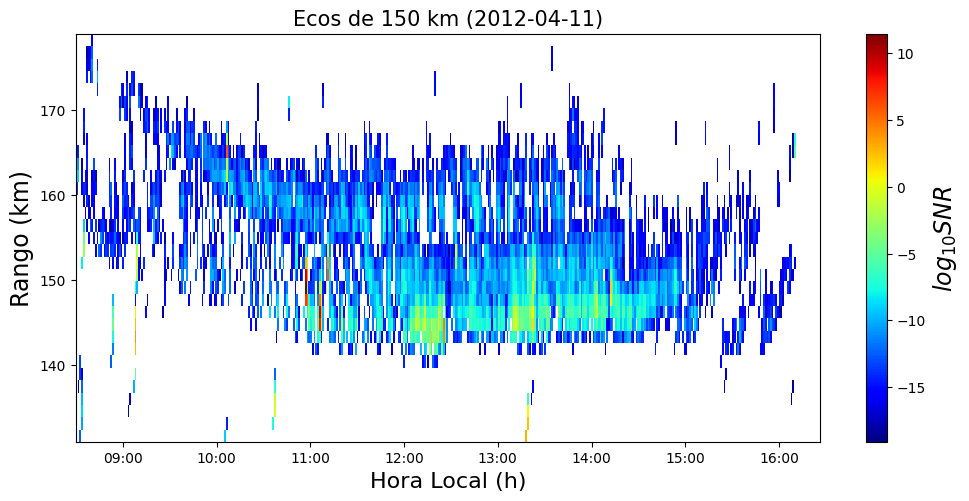

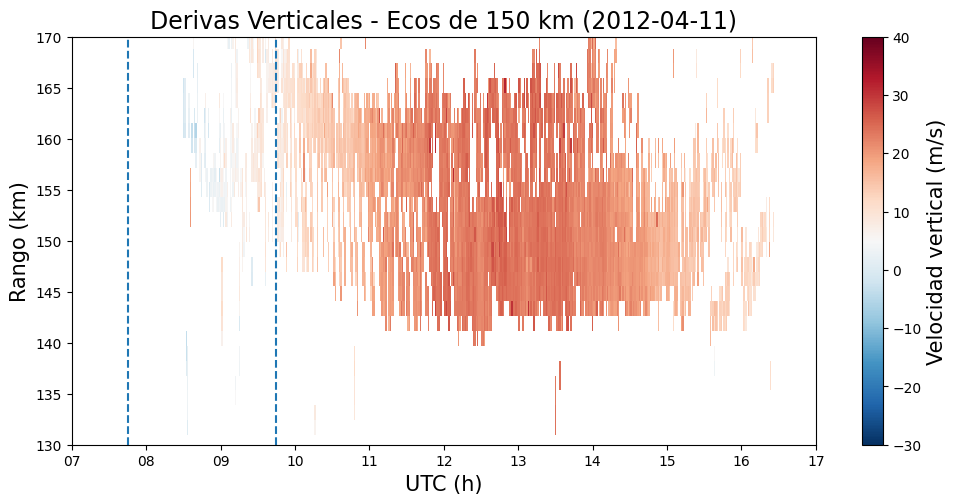

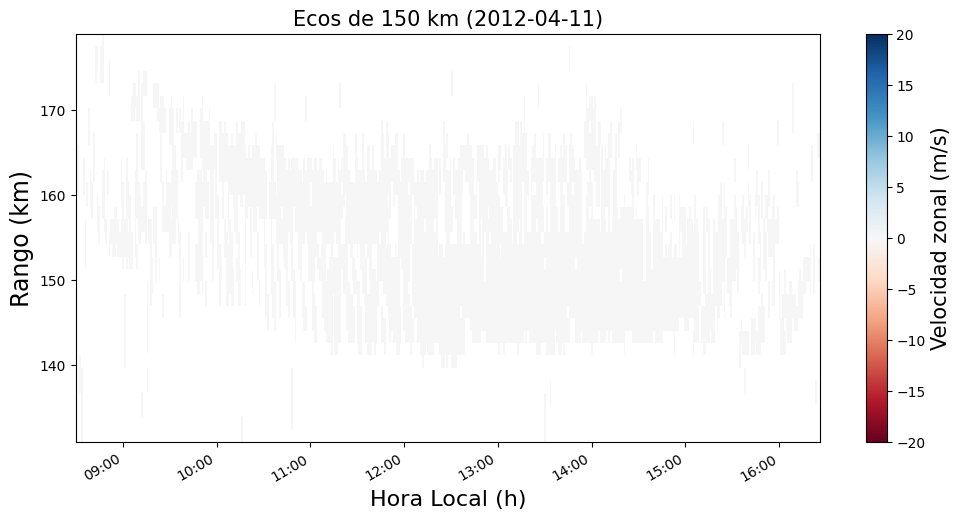

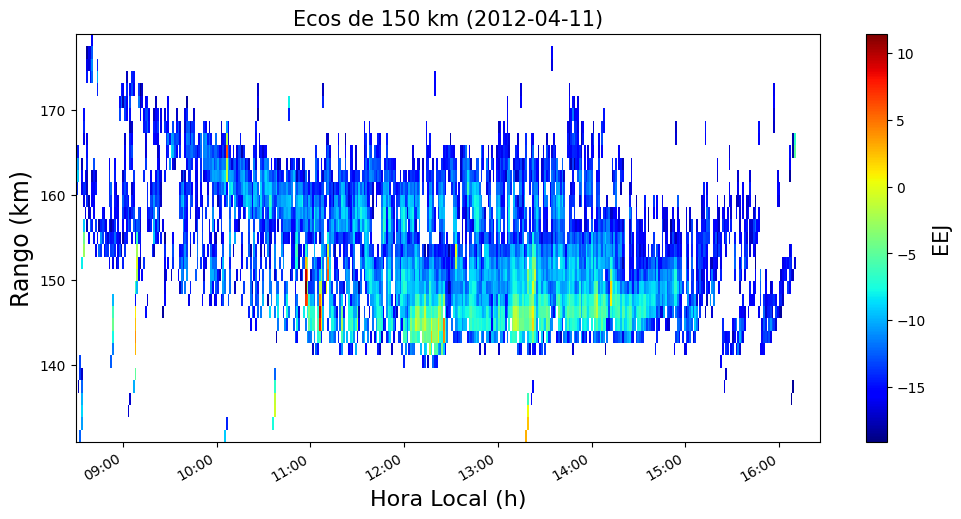

(33, 432) 2012-04-11 08:29:52 2012-04-11 16:26:07 61.0 130.95 178.95 1.5
Rango:  130.95 178.95


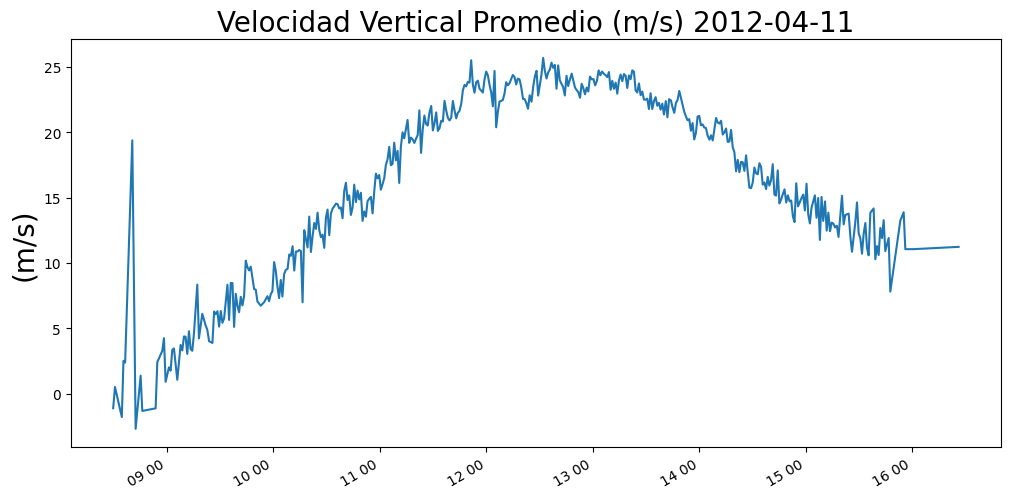

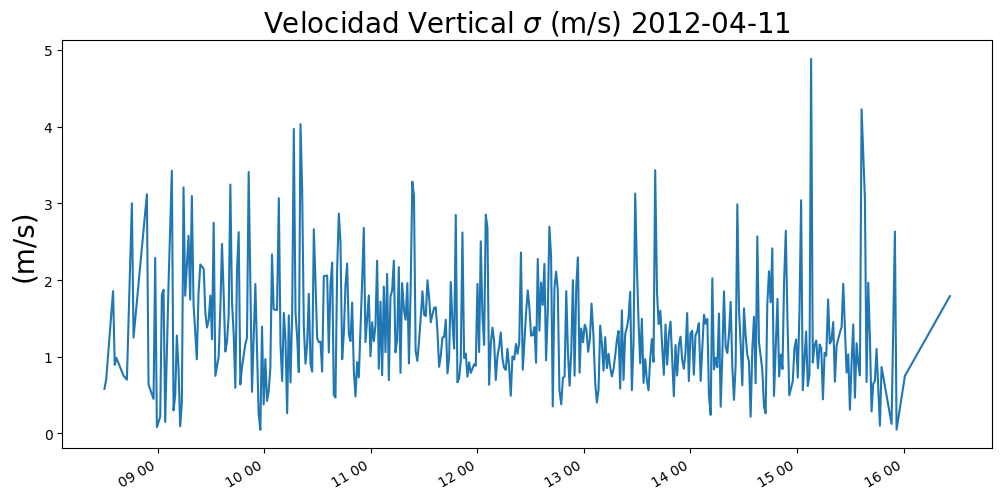

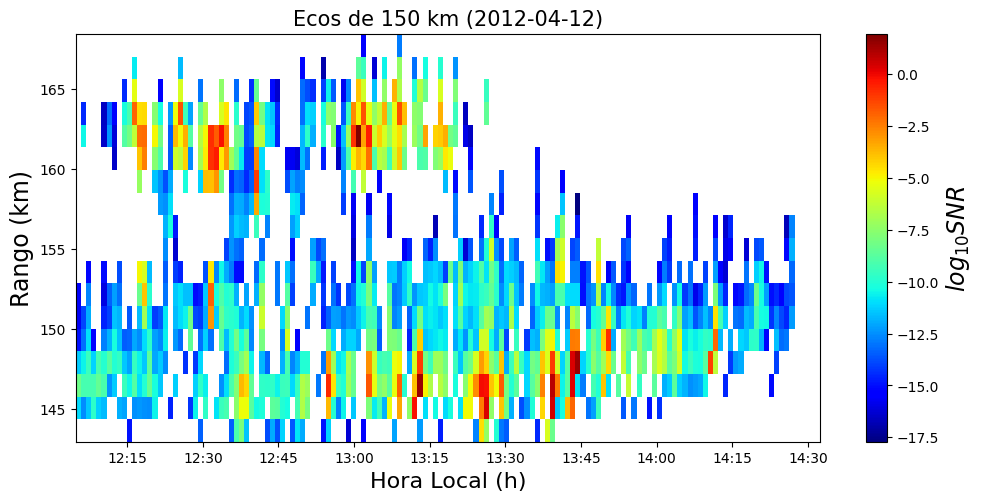

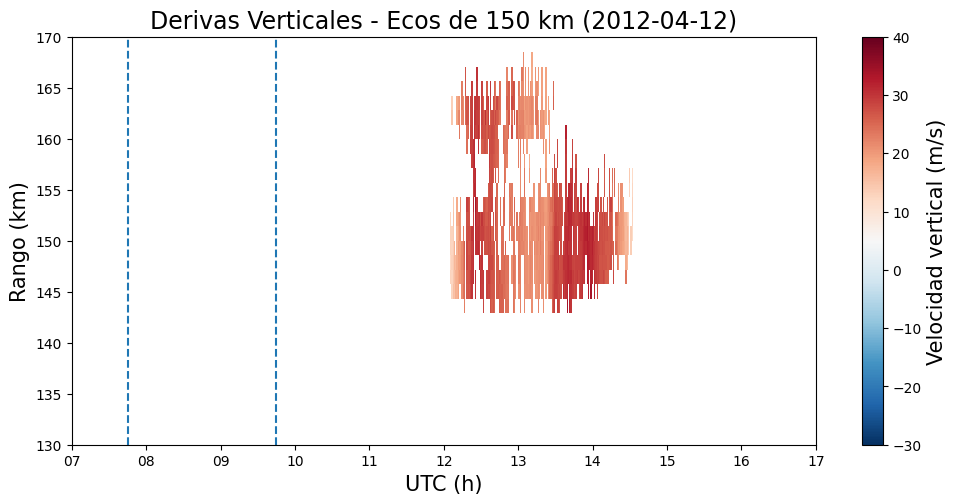

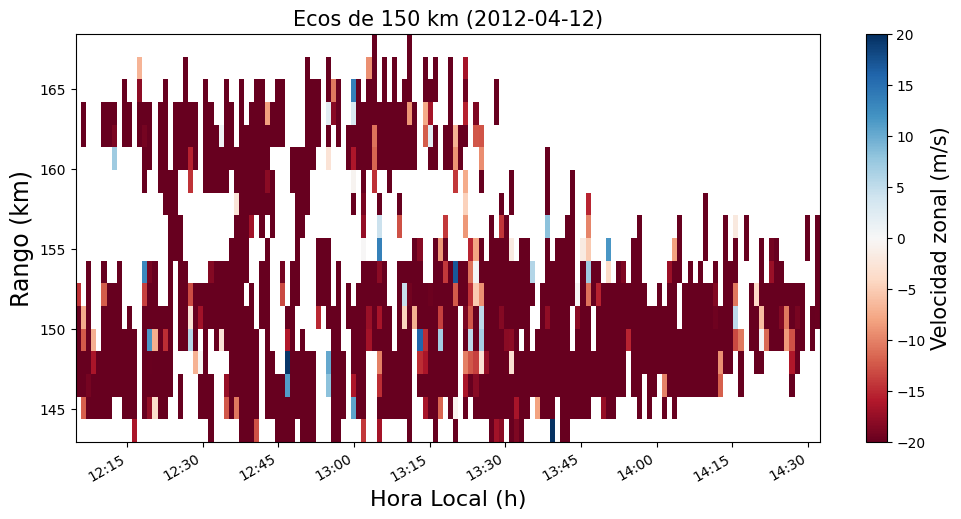

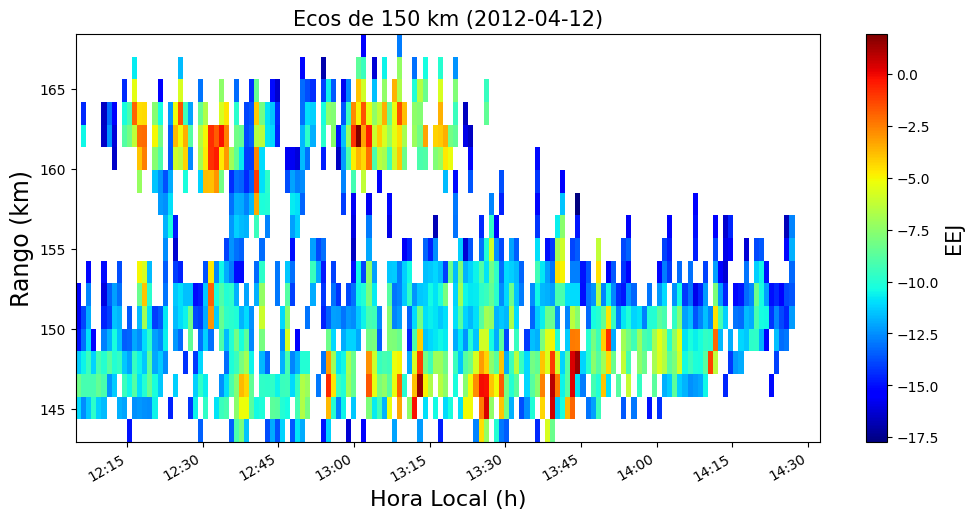

(18, 146) 2012-04-12 12:04:48 2012-04-12 14:32:21 62.0 142.95 168.45 1.5
Rango:  142.95 168.45


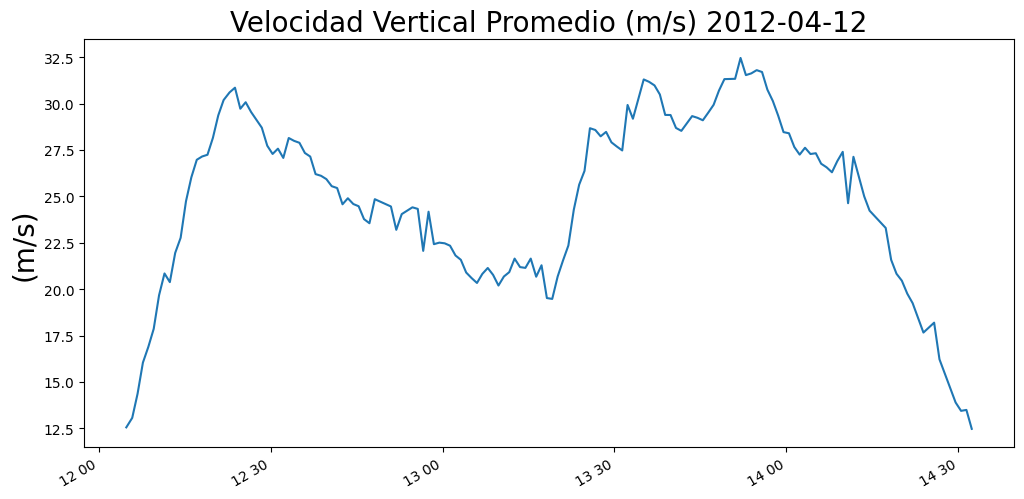

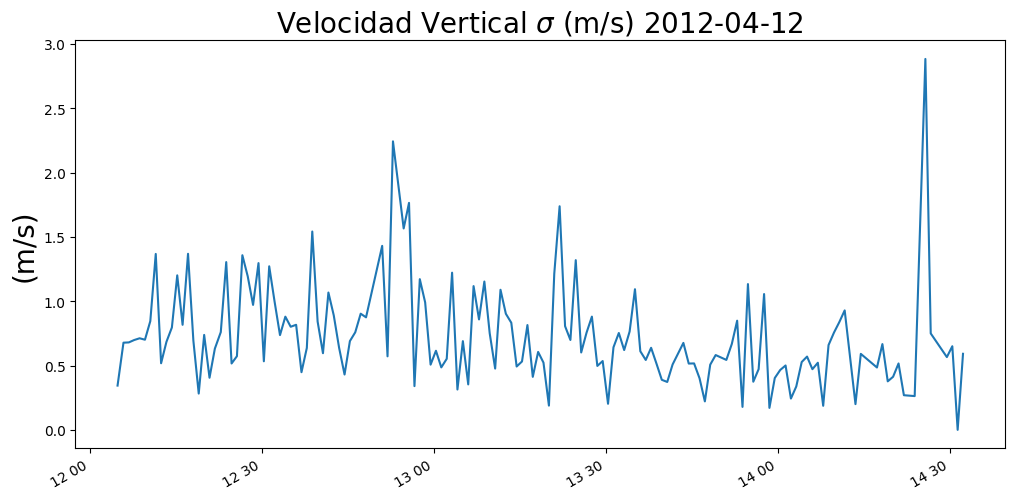

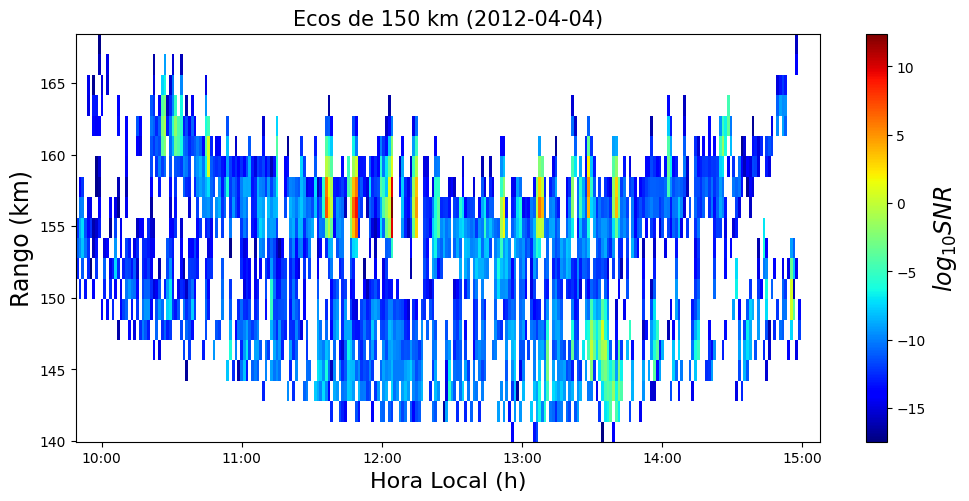

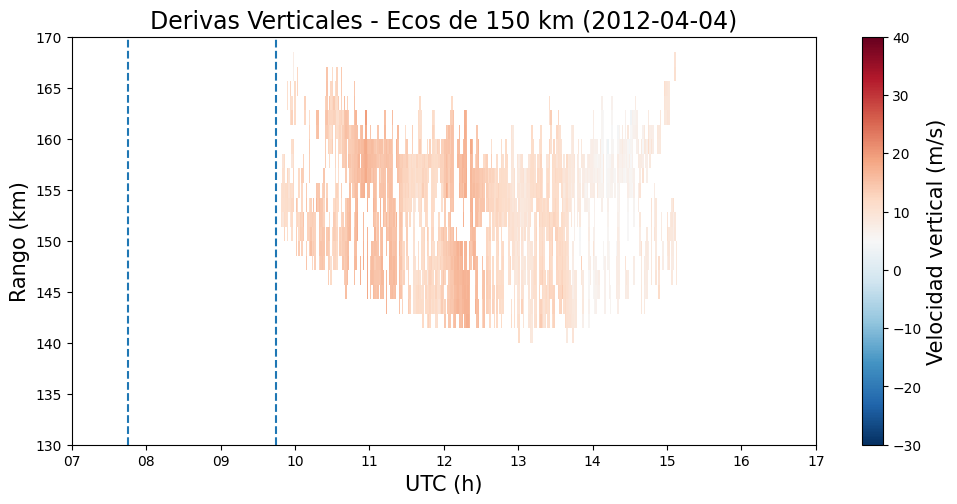

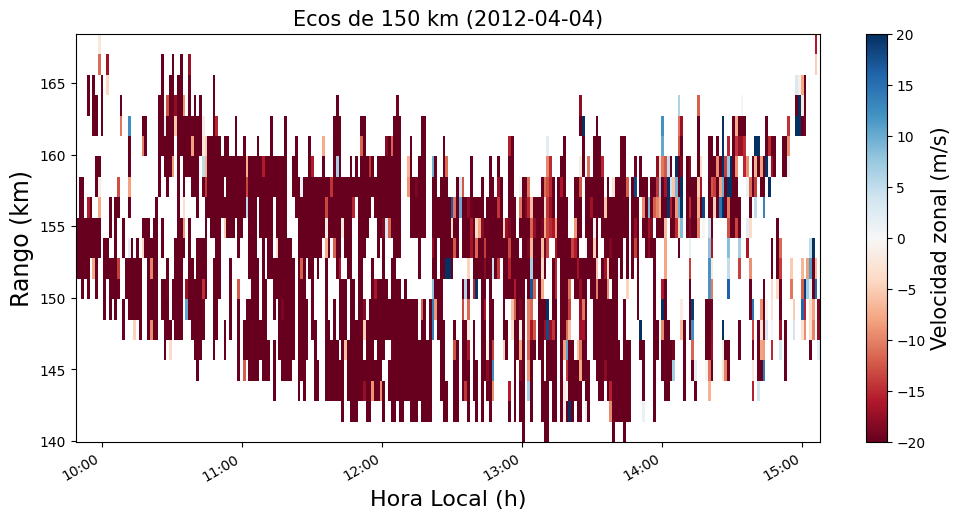

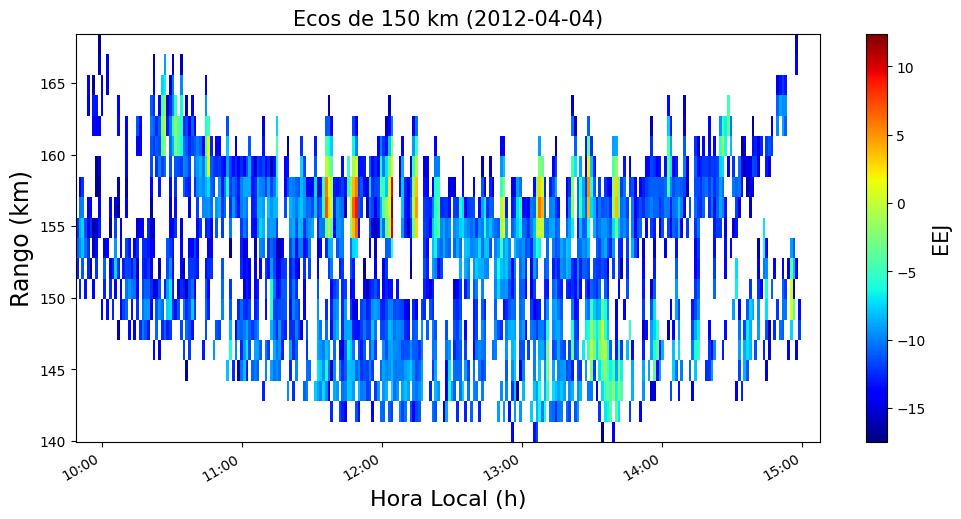

(20, 272) 2012-04-04 09:48:51 2012-04-04 15:07:35 169.0 139.95 168.45 1.5
Rango:  139.95 168.45


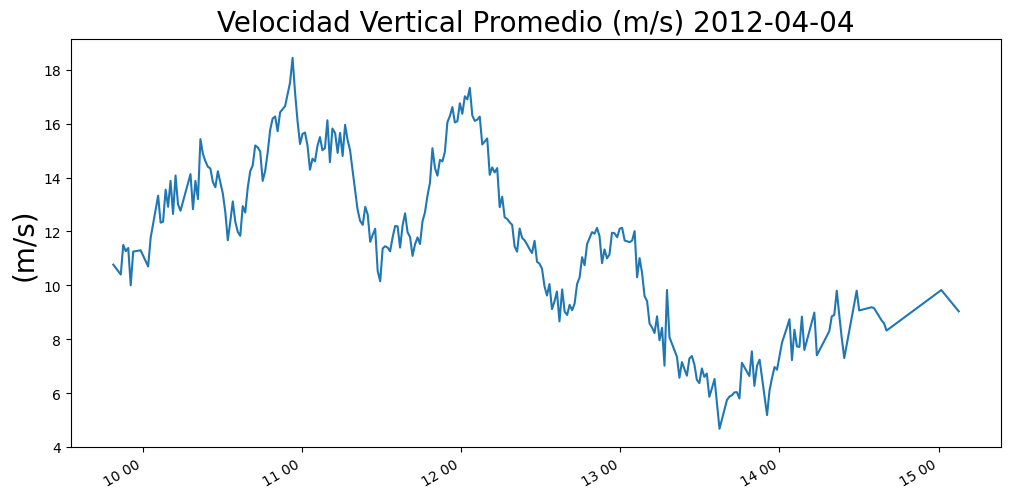

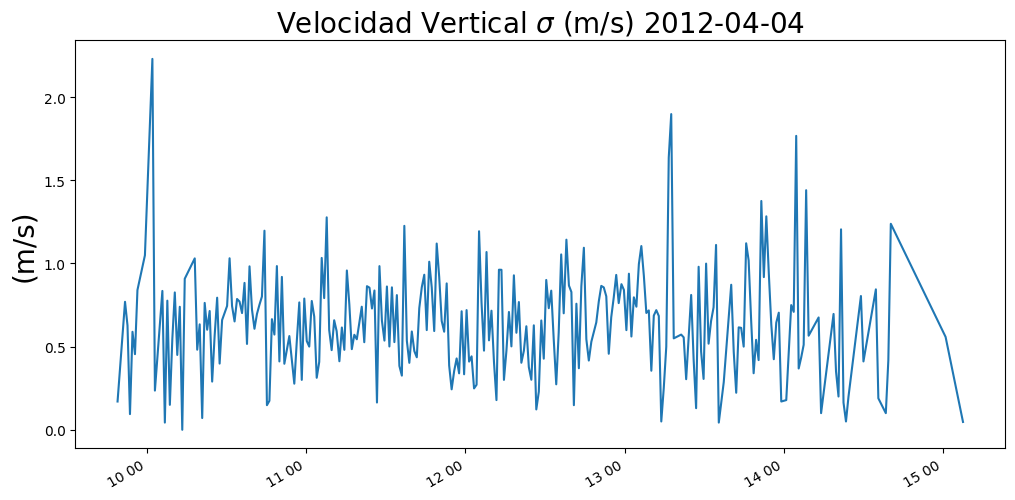

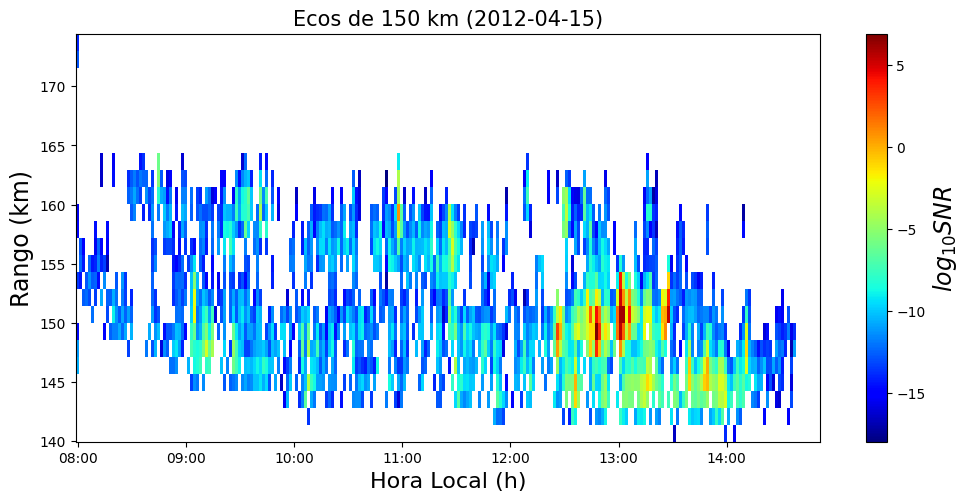

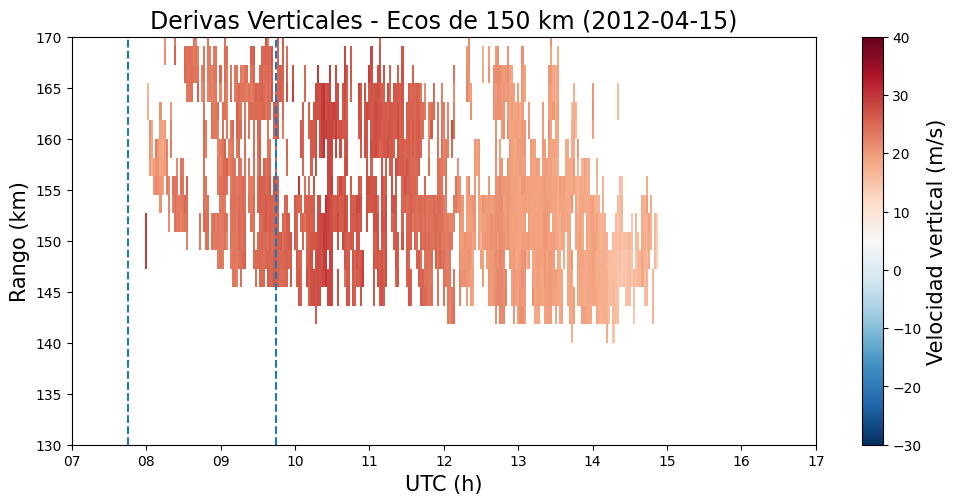

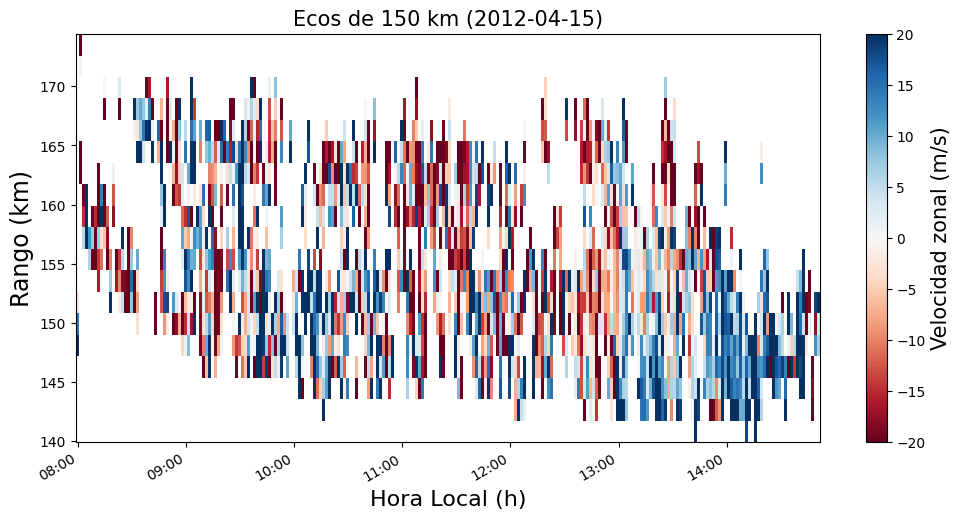

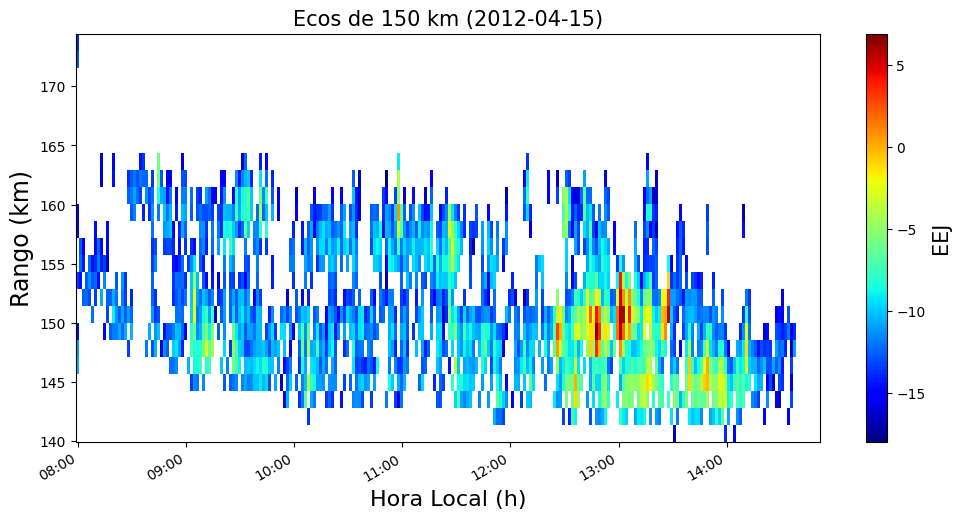

(24, 248) 2012-04-15 07:58:41 2012-04-15 14:51:42 4910.0 139.95 174.45 1.5
Rango:  139.95 174.45


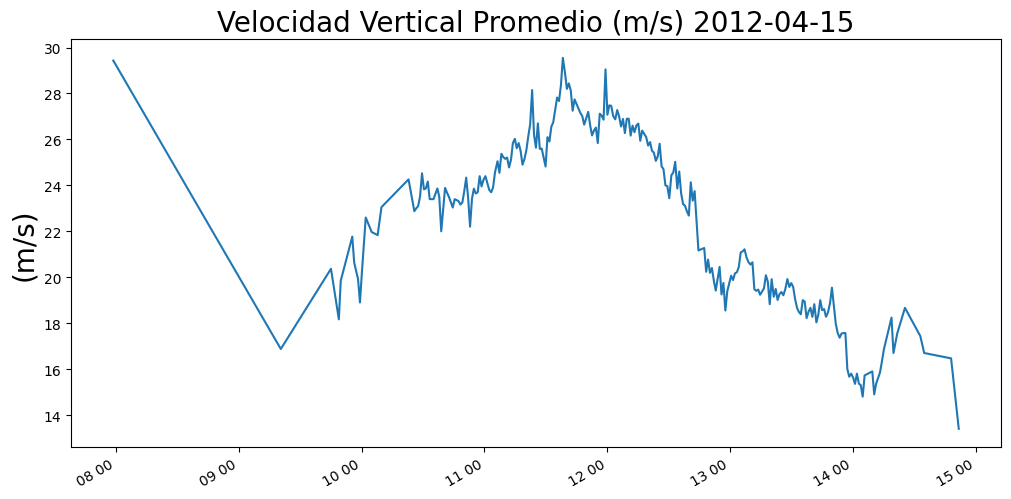

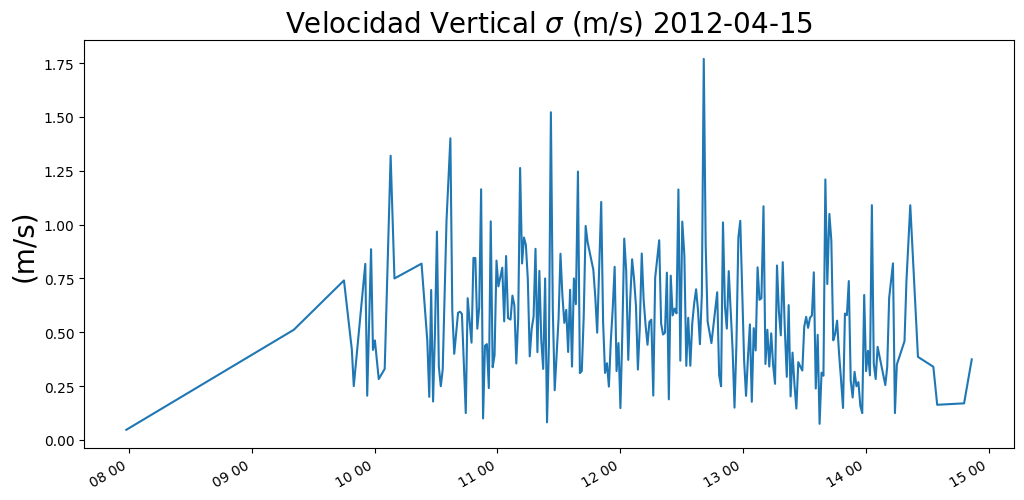

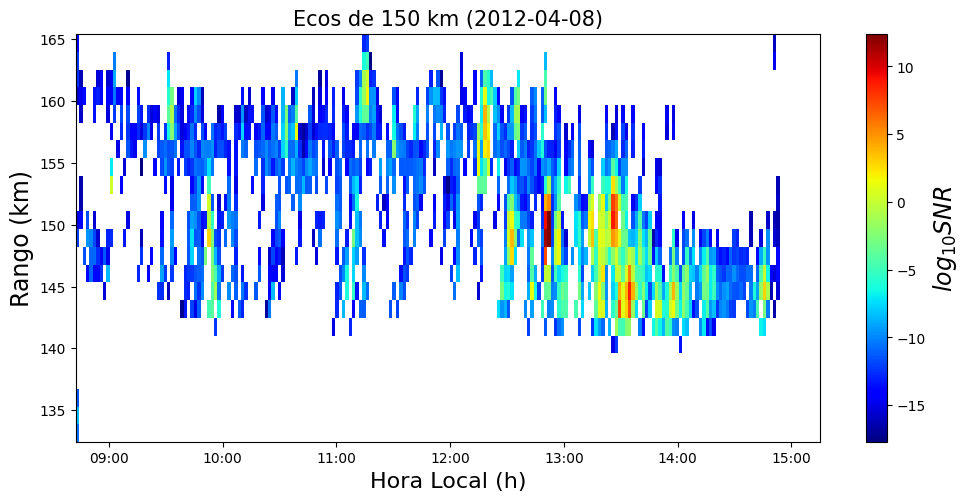

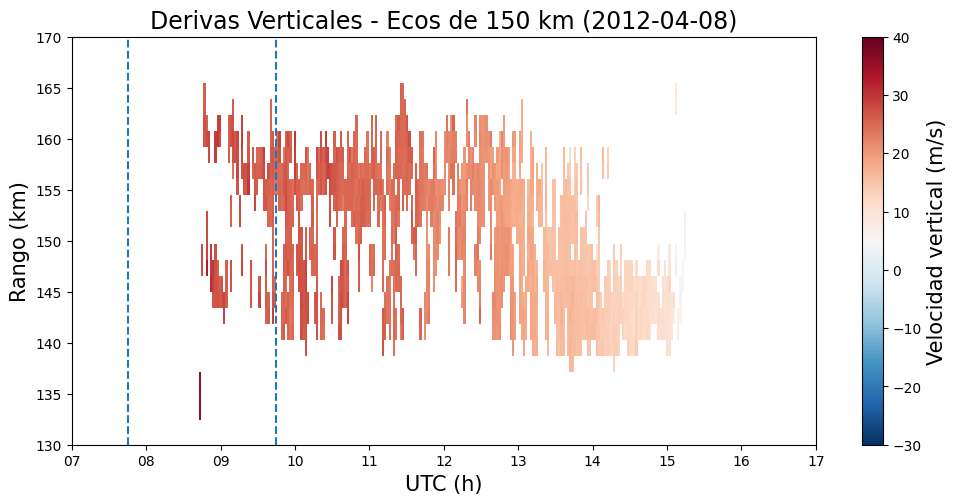

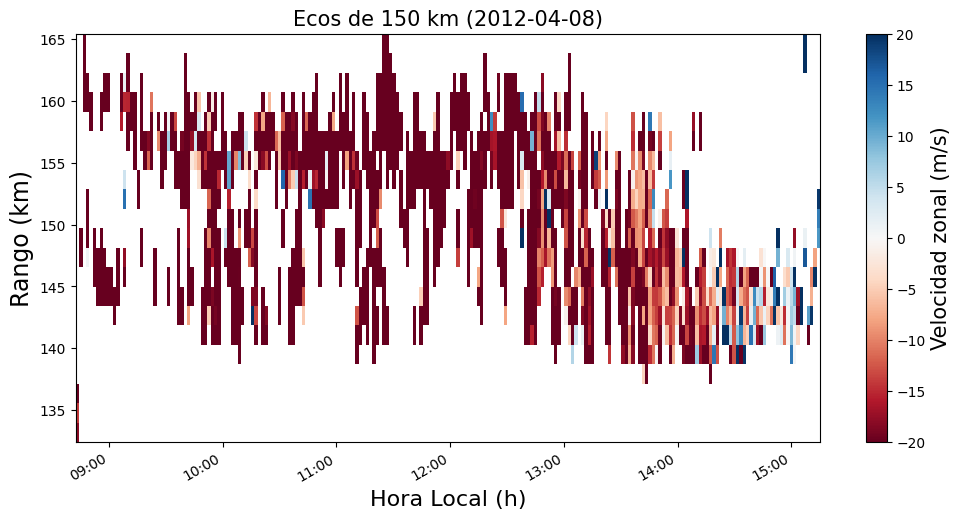

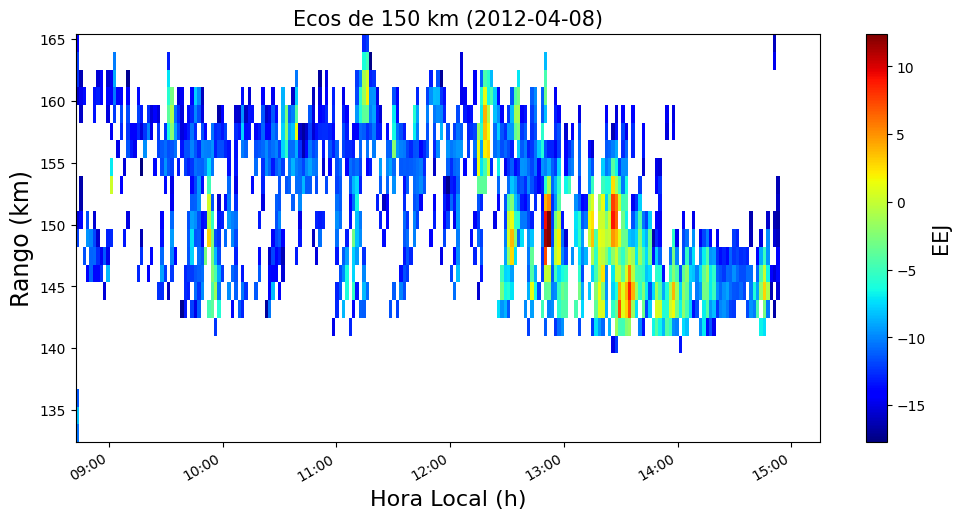

(23, 221) 2012-04-08 08:42:37 2012-04-08 15:14:56 4618.0 132.45 165.45 1.5
Rango:  132.45 165.45


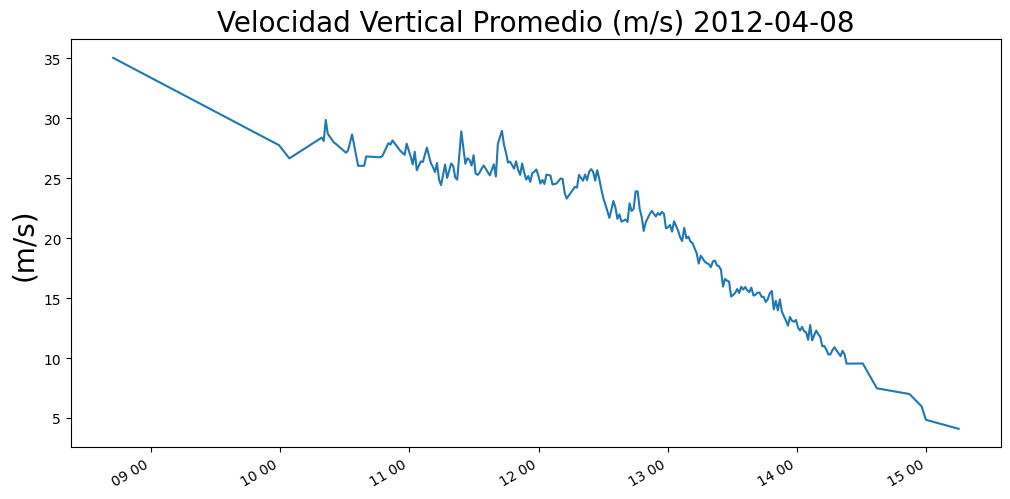

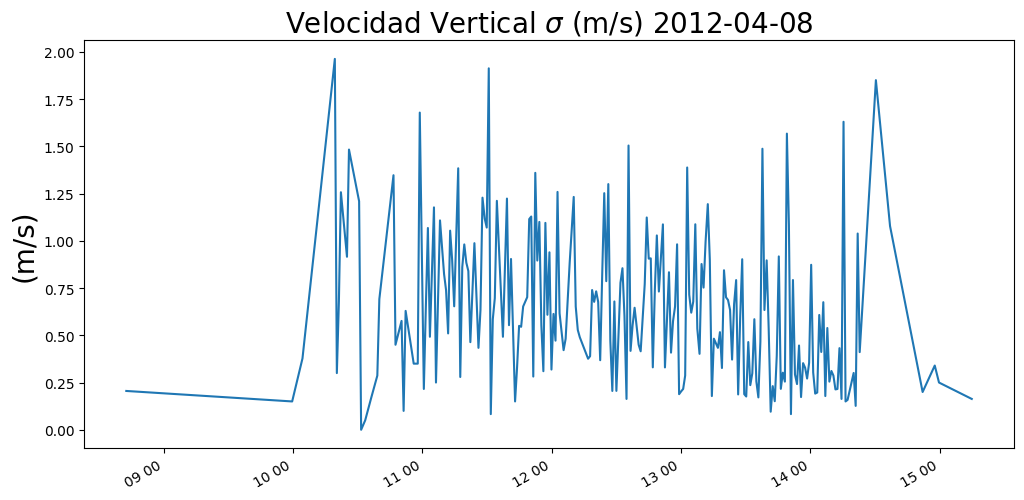

In [48]:
#'''
PlotFlag = True
plot_format= 'png'
h_min = []
h_max = []
frames_avg = []
frames_std = []
num_stamps = []
t_h_min = []
t_h_max = []
for filename in os.listdir(directory):
    if filename.endswith(".hdf5"):
        #print(os.path.join(directory, filename))
        data ,snl, index, range_array, rango, dir_plots, time_vector, v_zonal, v_vertical, timestamps, snl2 = GetMatrix_old(directory, filename, PlotFlag, plot_format)
        #print(data.shape, len(snl), index.shape, range_array.shape, len(rango))
        print(data.shape, index[0],index[-1], (index[1]-index[0]).total_seconds() ,range_array[0], range_array[-1], np.diff(range_array)[0]) 
        prev_times = [' ']
        k = 0
        for time in index:
            if prev_times[k] == time:
                   print('Same Time')
            else:
                #print 'Different time'
                if not time in prev_times:
                    prev_times.append(time)
                prev_time = time

        h_min.append(min(rango))
        h_max.append(max(rango))
    ###########################################################
        ran_max = max(rango)
        ran_min = min(rango)
        #rang_list = list(rango)
        print("Rango: ",ran_min, ran_max)
        max_index = rango.index(ran_max)
        min_index = rango.index(ran_min)
        #t_h_min.append(index[min_index].to_pydatetime())
        #t_h_max.append(index[max_index].to_pydatetime())
    ############################################################
        num_stamps.append(len(timestamps))
        prev_times = prev_times[1:]
        num_diff_times = len(prev_times)
        #print(num_diff_times)
        new_index = pd.DatetimeIndex(prev_times)
        index_ref = pd.DatetimeIndex(prev_times)
        if (new_index[0].hour <= 8):
            index_ref = new_index

        v_vert_avg = np.nanmean(v_vertical,axis=1)
        v_vert_std = np.nanstd(v_vertical,axis=1)
        df_std = pd.Series(v_vert_std, index=new_index)
        df = pd.Series(v_vert_avg, index=new_index)
        d = {'v_mean': v_vert_avg,'v_std': v_vert_avg,'time':new_index}
        pdf = pd.DataFrame(d)
        #df.set_index(index, inplace=True, drop=True)
        string_t0 = '%d-%02d-%02d %02d:%02d:00' % (new_index[0].year,new_index[0].month, new_index[0].day, 7,0)
        string_tf = '%d-%02d-%02d %02d:%02d:00' % (new_index[0].year,new_index[0].month, new_index[0].day, 17,0)
        
        if PlotFlag:
            fig, ax = plt.subplots(figsize=(12, 6))
            str_date = '%d-%02d-%02d' % (new_index[0].year,new_index[0].month,new_index[0].day)
            ax = df[string_t0:string_tf].plot()
            ax.set_ylabel('(m/s)', fontsize=20)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))

            ax.set_title('Velocidad Vertical Promedio (m/s) %s' % str_date, fontsize=20)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
            plt.savefig('%s/derivas-verticales/velocidad-vertical-promedio-%s.%s' % (dir_plots,str_date, plot_format))
            plt.show()
            plt.close(fig)
            
            fig1, ax1 = plt.subplots(figsize=(12, 6))
            ax1 = df_std[string_t0:string_tf].plot()
            ax1.set_ylabel('(m/s)', fontsize=20)
            ax1.set_title(r'Velocidad Vertical $\sigma$ (m/s) %s' % str_date, fontsize=20)
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
            plt.savefig('%s/derivas-verticales/velocidad-vertical-desviacion-estandar-%s.%s' % (dir_plots,str_date, plot_format))
            plt.show()
            plt.close(fig)
        frames_avg.append(df)#[string_t0:string_tf])
        frames_std.append(df_std)#[string_t0:string_tf])
#'''

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/juanpablo/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


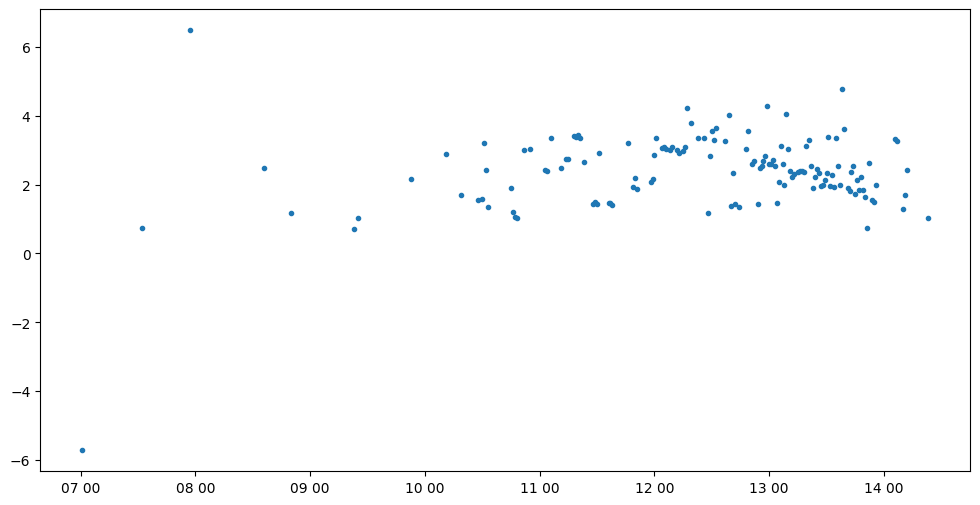

In [49]:
prom = np.nanmean(mat_drifts,axis=1)
std = np.nanstd(mat_drifts,axis=1)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(mdates.date2num(time_range),prom,'.')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))

In [50]:
time_range_prime, range_fixed_prime = GetTimeRangeArrays(year, month, days[-1], 7, 19,130,180,1.5,60)


1:00:00
time_range.shape:  (12,)


In [51]:
#modProm = np.nanmean(matModel,axis=0)
#stdMod = np.nanstd(matModel,axis=0)
#print(modProm.shape)
#fig, ax = plt.subplots(figsize=(12, 7))
#fig = plt.figure(figsize=(30,10))
'''
ax=fig.add_subplot(111, label="1")

#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
ax.errorbar(mdates.date2num(time_range), modProm, yerr=stdMod, label='Scherliess-Fejer',marker='o',color='red',lw=2)
#ax.plot(mdates.date2num(listTimes[-1]),modProm,'.')
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

ax2=fig.add_subplot(111, label="2")#, frame_on=False)
ax2.plt = ax2.errorbar(mdates.date2num(time_range), prom, yerr=std, label='Derivas Verticales',marker='o',color='black',lw=2)
ax2.set_title('Derivas verticales - Ecos de 150 km', fontsize=32)
ax2.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax2.xaxis.set_major_formatter(date_format)
ax2.xaxis.set_tick_params(labelsize=28)
ax2.yaxis.set_tick_params(labelsize=28)
ax2.set_xlabel('Hora Local',fontsize=29)
ax2.set_ylabel('Derivas verticales (m/s)',fontsize=29)

ax3=fig.add_subplot(111, label="3", frame_on=False)
ax3.plt = ax3.errorbar(mdates.date2num(time_range), modProm, yerr=stdMod, label='Sherliess-Fejer',marker='o',color='red',lw=4)
ax3.xaxis_date()
ax3.xaxis.set_major_formatter(date_format)
#ax3.set_xlim([dates.date2num(dti_prime),dates.date2num(dtf_prime)])
ax3.axes.xaxis.set_ticklabels([])
ax3.axes.yaxis.set_ticklabels([])
fig.legend(loc = (0.78, 0.81), ncol=1, borderaxespad=10, fontsize=25)
'''
#'''
#ax2.set_ylim([-30,30])
#ax2.set_xlim([7.5,16.5])#7.5,19.5
#mod_series_avg.groupby(mod_series_avg.index.hour).mean().plot(yerr=mod_series_avg.groupby(mod_series_avg.index.hour).std(),rot=0,ax=axs)
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )


'\nax=fig.add_subplot(111, label="1")\n\n#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap=\'jet\')\nax.errorbar(mdates.date2num(time_range), modProm, yerr=stdMod, label=\'Scherliess-Fejer\',marker=\'o\',color=\'red\',lw=2)\n#ax.plot(mdates.date2num(listTimes[-1]),modProm,\'.\')\nax.xaxis_date()\ndate_format = mdates.DateFormatter(\'%H:%M\')\nax.xaxis.set_major_formatter(date_format)\nax.xaxis.set_tick_params(labelsize=18)\nax.yaxis.set_tick_params(labelsize=18)\n\nax2=fig.add_subplot(111, label="2")#, frame_on=False)\nax2.plt = ax2.errorbar(mdates.date2num(time_range), prom, yerr=std, label=\'Derivas Verticales\',marker=\'o\',color=\'black\',lw=2)\nax2.set_title(\'Derivas verticales - Ecos de 150 km\', fontsize=32)\nax2.xaxis_date()\ndate_format = mdates.DateFormatter(\'%H:%M\')\nax2.xaxis.set_major_formatter(date_format)\nax2.xaxis.set_tick_params(labelsize=28)\nax2.yaxis.set_tick_params(labelsize=28)\nax2.set_xlabel(\'Hora Local\',fontsize=29)\nax2.set

In [52]:
#print(prom)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


Abril-2012


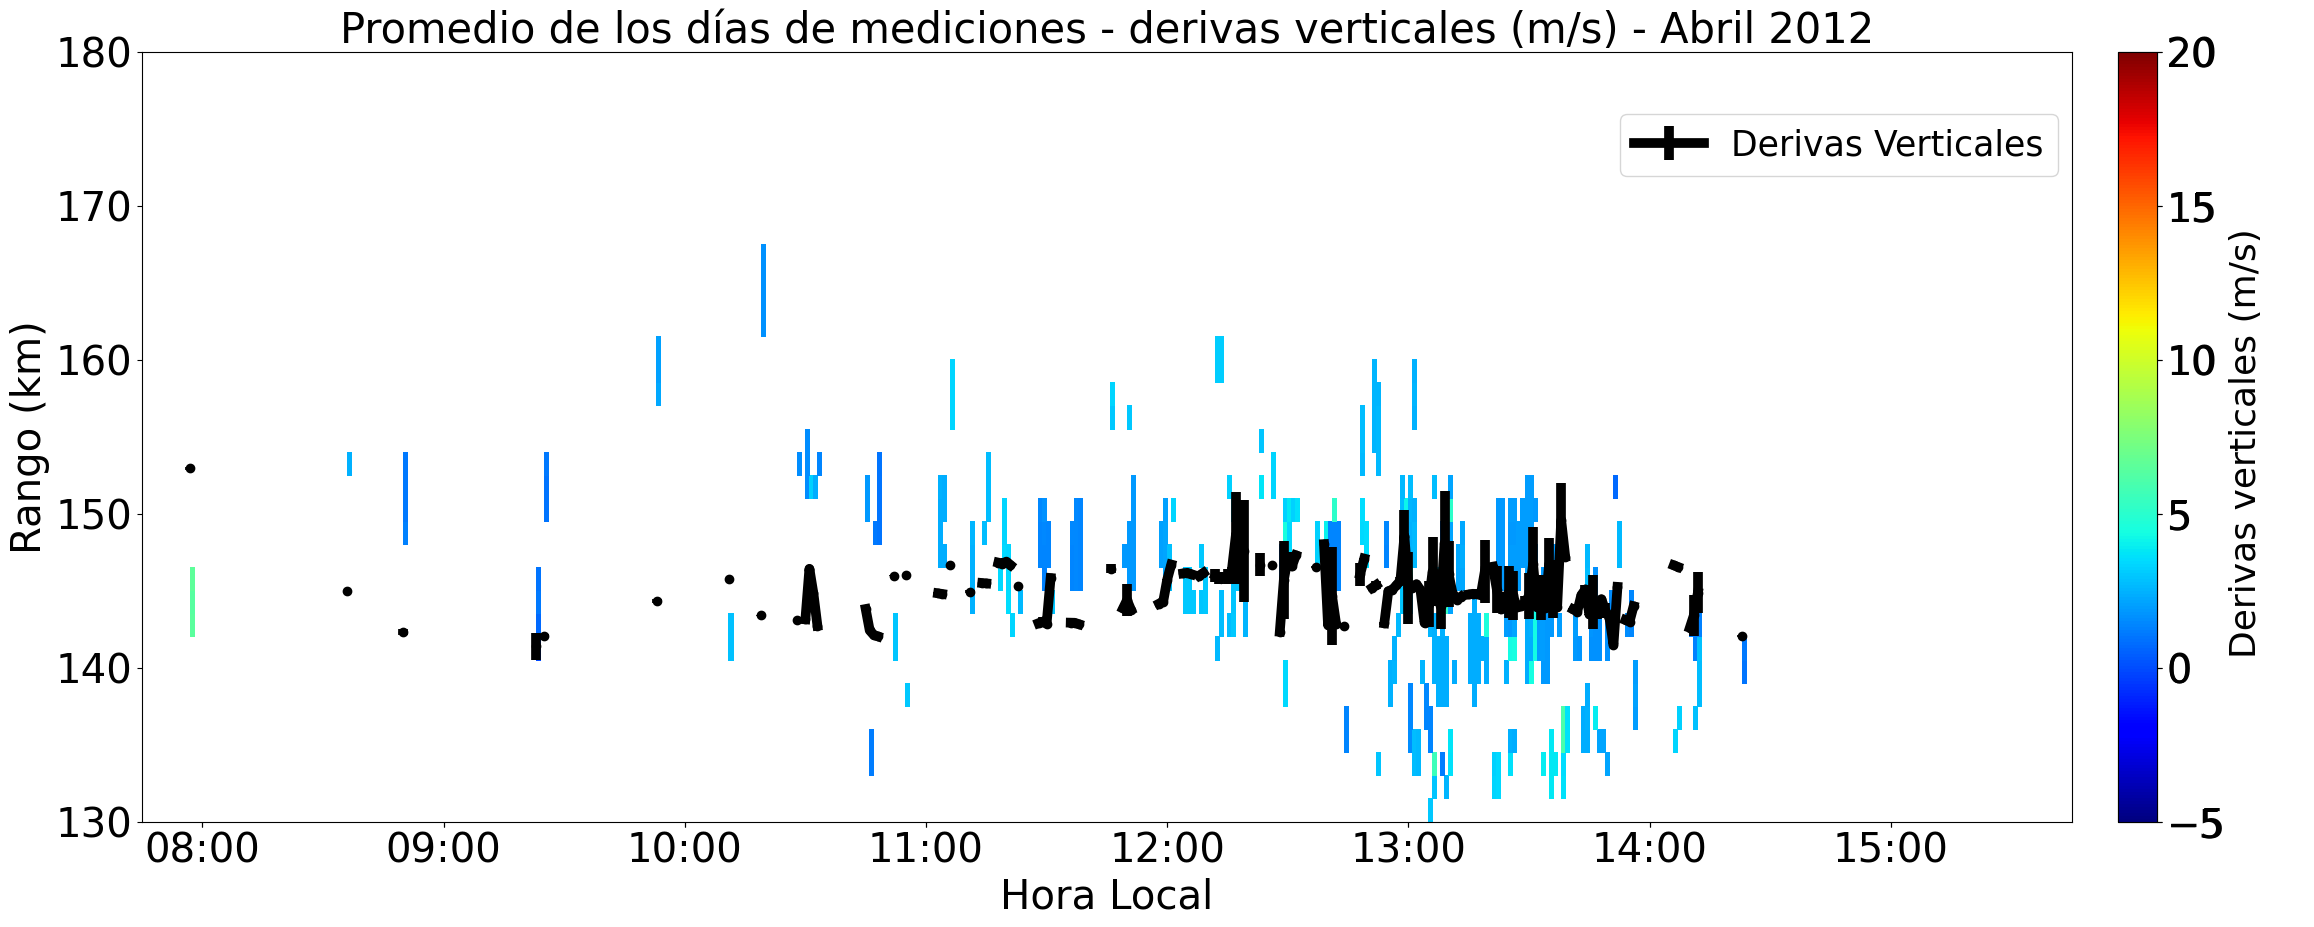

In [53]:
plot_format = 'png'
fig = plt.figure(figsize=(30,10))
plt.rcParams['ytick.labelsize']=29
plt.rcParams['xtick.labelsize']=29
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
#ax3=fig.add_subplot(111, label="3", frame_on=False)
#plt.title("Promedio de los días de mediciones - derivas verticales (m/s) - %s" % GetMonth(month) ,fontsize=30)
#plt.title("Promedio de los días de mediciones - derivas verticales (m/s) - %s" % 'Noviembre-Diciembre' ,fontsize=30)
plt.title("Promedio de los días de mediciones - derivas verticales (m/s) - %s %d" % (GetMonth(month),year) ,fontsize=30)

color_palette='jet'#'seismic'#'seismic_r'#'jet'#'RdBu_r'#'plasma'
ax.plt=ax.pcolormesh(mdates.date2num(time_range), range_fixed, mat_drifts.T,cmap=color_palette)#'RdBu_r')#'jet')

#ax.plt= ax.pcolormesh(dt_array, range_array, avgMat, cmap=plt.cm.RdBu_r)

color='red'
#color='white'
ax.set_xlabel('Hora Local',fontsize=29)
ax.set_ylabel('Rango (km)',fontsize=29)
#ax.set_ylim(300, 400)
#ax.set_ylim(250, 500)
#ax.set_xlim([mdates.date2num(dt_array[ind_i]),mdates.date2num(dt_array[ind_f])])
str_ti = '%d-%02d-%02d %02d:%02d:00' % (year,month,time_range[-1].day,7,45)
str_tf = '%d-%02d-%02d %02d:%02d:00' % (year,month,time_range[-1].day,15,45)

dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')

str_ti_prime = '%d-%02d-%02d %02d:%02d:00' % (year,month,time_range[-1].day,7,45)
str_tf_prime = '%d-%02d-%02d %02d:%02d:00' % (year,month,time_range[-1].day,15,45)
dti_prime = datetime.datetime.strptime(str_ti_prime, '%Y-%m-%d %H:%M:%S')
dtf_prime = datetime.datetime.strptime(str_tf_prime, '%Y-%m-%d %H:%M:%S')

ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])

ax.set_ylim(130, 180)
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
color_aux='white'
width_aux=6

cbar=fig.colorbar(ax.plt,ax=ax,pad=0.02)
cbar.set_label(r'Derivas verticales (m/s) ', fontsize=26)
cbar.ax.tick_params(labelsize=28)


#ax2.plt = ax2.plot(mdates.date2num(time_range),prom,marker='o',color='black',lw=8)
ax2.plt = ax2.errorbar(mdates.date2num(time_range), prom, yerr=std, label='Derivas Verticales',marker='o',color='black',lw=7)
ax2.xaxis_date()
#print(prom)
#ax2.errorbar(mdates.date2num(time_objects_avg), list_avg, yerr=list_std, label='Derivas Verticales',marker='o',color='black',lw=8)
#plt.legend(loc="upper left",prop={'size':25})
#ax2.axes.yaxis.set_ticklabels([])
#ax2.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
ax2.axes.yaxis.set_visible(False)

ax2.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
#print(len(time_range), len(list_avg),len(list_std))
#'''
ax2.set_ylim([-5,20])
#ax3.plt = ax3.errorbar(mdates.date2num(time_range), modProm, yerr=stdMod, label='Scherliess-Fejer',marker='o',color='red',lw=7)
#ax3.xaxis_date()
#ax3.yaxis.tick_right()

#ax3.xaxis.set_major_formatter(date_format)
#ax3.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
#ax3.axes.xaxis.set_ticklabels([])
#ax3.axes.yaxis.set_ticklabels([])
#ax3.axes.yaxis.set_visible(False)

#'''
#ax3.set_ylim([-5,20])
#ax2.set_xlim([7.5,16.5])#7.5,19.5
#mod_series_avg.groupby(mod_series_avg.index.hour).mean().plot(yerr=mod_series_avg.groupby(mod_series_avg.index.hour).std(),rot=0,ax=axs)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )

#ax2.set_ylim([-15,20])
#ax2.set_xlim([7.5,17.5])#7.5,19.5
cbar2=fig.colorbar(ax.plt,ax=ax2,pad=0.02)
#cbar3=fig.colorbar(ax.plt,ax=ax3,pad=0.02)
#cbar2.remove()
cbar.mappable.set_clim(-5,20)

print(current_month)
plot_format='png'
#plt.legend()
fig.legend(loc = (0.7, 0.81), ncol=1, borderaxespad=10, fontsize=25)
plt.savefig('%s/filtered-%dmin-%s-RTI-promedio-vs-modelo-promedio-derivas-verticales-ecos-de-150km-%s.%s' % (plots_boletin,intFactor,color_palette,current_month,plot_format),dpi=500,bbox_inches="tight")
#plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':


Abril-2012


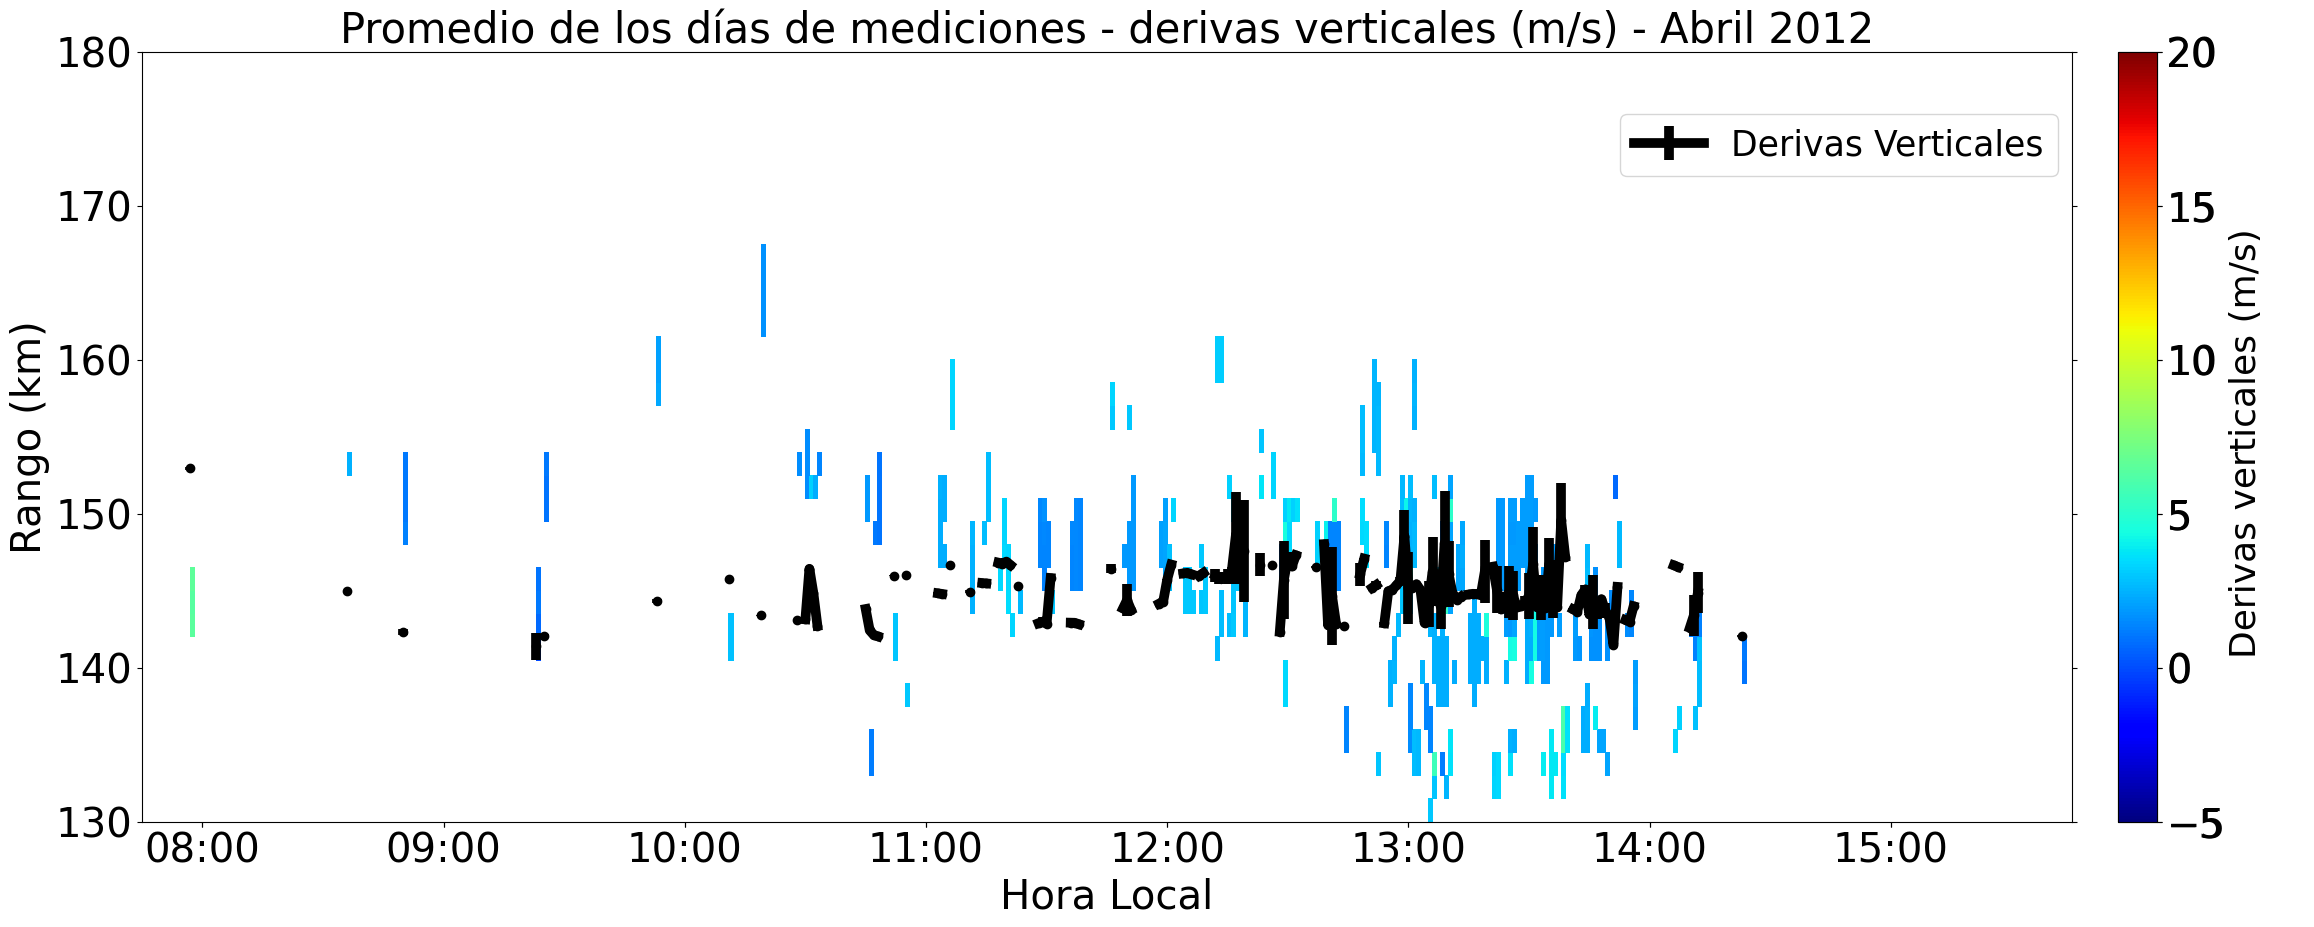

In [54]:
plot_format = 'png'
fig = plt.figure(figsize=(30,10))
plt.rcParams['ytick.labelsize']=29
plt.rcParams['xtick.labelsize']=29
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
#ax3=fig.add_subplot(111, label="3", frame_on=False)
#plt.title("Promedio de los días de mediciones - derivas verticales (m/s) - %s" % 'Noviembre-Diciembre' ,fontsize=30)
plt.title("Promedio de los días de mediciones - derivas verticales (m/s) - %s %d" % (GetMonth(month),year) ,fontsize=30)

color_palette='jet'#'seismic'#'seismic_r'#'jet'#'RdBu_r'#'plasma'
ax.plt=ax.pcolormesh(mdates.date2num(time_range), range_fixed, mat_drifts.T,cmap=color_palette)#'RdBu_r')#'jet')

#ax.plt= ax.pcolormesh(dt_array, range_array, avgMat, cmap=plt.cm.RdBu_r)

color='red'
#color='white'
ax.set_xlabel('Hora Local',fontsize=29)
ax.set_ylabel('Rango (km)',fontsize=29)
#ax.set_ylim(300, 400)
#ax.set_ylim(250, 500)
#ax.set_xlim([mdates.date2num(dt_array[ind_i]),mdates.date2num(dt_array[ind_f])])
str_ti = '%d-%02d-%02d %02d:%02d:00' % (year,month,time_range[-1].day,7,45)
str_tf = '%d-%02d-%02d %02d:%02d:00' % (year,month,time_range[-1].day,15,45)

dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')

str_ti_prime = '%d-%02d-%02d %02d:%02d:00' % (year,month,time_range[-1].day,7,45)
str_tf_prime = '%d-%02d-%02d %02d:%02d:00' % (year,month,time_range[-1].day,15,45)
dti_prime = datetime.datetime.strptime(str_ti_prime, '%Y-%m-%d %H:%M:%S')
dtf_prime = datetime.datetime.strptime(str_tf_prime, '%Y-%m-%d %H:%M:%S')

ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])

ax.set_ylim(130, 180)
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
color_aux='white'
width_aux=6

cbar=fig.colorbar(ax.plt,ax=ax,pad=0.02)
cbar.set_label(r'Derivas verticales (m/s) ', fontsize=26)
cbar.ax.tick_params(labelsize=28)


#ax2.plt = ax2.plot(mdates.date2num(time_range),prom,marker='o',color='black',lw=8)
ax2.plt = ax2.errorbar(mdates.date2num(time_range), prom, yerr=std, label='Derivas Verticales',marker='o',color='black',lw=7)
ax2.xaxis_date()
#print(prom)
#ax2.errorbar(mdates.date2num(time_objects_avg), list_avg, yerr=list_std, label='Derivas Verticales',marker='o',color='black',lw=8)
#plt.legend(loc="upper left",prop={'size':25})
#ax2.axes.yaxis.set_ticklabels([])
#ax2.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
#ax2.axes.yaxis.set_visible(False)

ax2.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
#print(len(time_range), len(list_avg),len(list_std))
#'''
ax2.set_ylim([-5,20])
#ax3.plt = ax3.errorbar(mdates.date2num(time_range), modProm, yerr=stdMod, label='Scherliess-Fejer',marker='o',color='red',lw=7)
#ax3.xaxis_date()
ax2.yaxis.tick_right()
ax2.axes.yaxis.set_ticklabels([])
#nan_series={}
#ax2.get_xaxis().set_visible(False)
#ax2.yaxis.tick_right()
#ax3.xaxis.set_major_formatter(date_format)
#ax3.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
#ax3.axes.xaxis.set_ticklabels([])
#ax3.axes.yaxis.set_ticklabels([])
#ax3.axes.yaxis.set_visible(False)

#'''
#ax3.set_ylim([-5,20])
#ax2.set_xlim([7.5,16.5])#7.5,19.5
#mod_series_avg.groupby(mod_series_avg.index.hour).mean().plot(yerr=mod_series_avg.groupby(mod_series_avg.index.hour).std(),rot=0,ax=axs)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )

#ax2.set_ylim([-15,20])
#ax2.set_xlim([7.5,17.5])#7.5,19.5
cbar2=fig.colorbar(ax.plt,ax=ax2,pad=0.02)
#cbar3=fig.colorbar(ax.plt,ax=ax3,pad=0.02)
#cbar2.remove()
cbar.mappable.set_clim(-5,20)

print(current_month)
plot_format='png'
#plt.legend()
fig.legend(loc = (0.7, 0.81), ncol=1, borderaxespad=10, fontsize=25)
plt.savefig('%s/filtered-%dmin-%s-RTI-promedio-vs-modelo-promedio-derivas-verticales-ecos-de-150km-%s.%s' % (plots_boletin,intFactor,color_palette,current_month,plot_format),dpi=500,bbox_inches="tight")
#plt.show()

In [55]:
dir_plots

'Plots-150km-Abril-2012'